# r/sustainability (2008–2022): end-to-end pipeline (Drive → Parquet → Analysis)

**What I’m doing here**
- I mount Google Drive and point to the two files I uploaded:
  - `sustainability_comments.zst` (all comments to Dec 2022)
  - `sustainability_submissions.zst` (all submissions to Dec 2022)
- I inspect a few raw lines to understand the **JSON structure** (which fields are available).
- I **stream** each big `.zst` file, keep only years **2008–2022**, and write **per-year Parquet** files to Drive.
- I log **how many comments** and **how many submissions** I kept, so I have defensible counts for the report.

**What I will run only once**
- The two “stream to Parquet” cells are heavy. I will run them once to create per-year Parquet files.
- On later sessions, I will **comment them out** and load the saved Parquet instead.

**later cells**
- Load Parquet → light cleaning → (for whole-subreddit analysis) **BERTopic** to discover themes.
- Then: **emotions** (GoEmotions), **polarity** (RoBERTa + VADER), **subjectivity** (TextBlob).
- Aggregate by **topic** and **month** for short/long-term patterns.


# Setup and Imports

In [ ]:
!pip install \
    zstandard \
    pandas \
    pyarrow \
    emoji \
    textblob \
    sentence-transformers \
    bertopic \
    scikit-learn \
    transformers \
    torch \
    nrclex \
    vaderSentiment

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.2 MB/s eta 0:00:00
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=0844f6da379ae8abb849fa2beebfdb169c557bca91c3dc64560a22ca68c63605
  Stored in directory: /root/.cache/pip/wheels/1f/e8/d0/e3c3da0ef3b37ef4381dbf5c9401f3a9861a63ce221b13d8bb
Successfully built nrclex


In [ ]:
# ------------------------------
# CORE PYTHON
# ------------------------------
import os
import io
import gc
import re
import math
import time
import json
import hashlib
from pathlib import Path
from datetime import datetime, timezone
from collections import Counter

# ------------------------------
# DATA & STORAGE
# ------------------------------
import numpy as np
import pandas as pd
import glob

# ------------------------------
# COMPRESSION / FORMATS
# ------------------------------
import zstandard as zstd

# ------------------------------
# NLP / EMBEDDINGS / TOPICS
# ------------------------------
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer

# ------------------------------
# TRANSFORMERS (GoEmotions, etc.)
# ------------------------------
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ------------------------------
# EMOTION & SENTIMENT MODELS
# ------------------------------
from nrclex import NRCLex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# ------------------------------
# VISUALIZATION
# ------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# # ------------------------------
# # COLAB UTILITIES
# # ------------------------------
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Directories containing *raw* yearly parquet chunks
RC_DIR = "/content/drive/MyDrive/r_sustainability/RC"
RS_DIR = "/content/drive/MyDrive/r_sustainability/RS"

# Load all raw comment files
rc_files = sorted(glob.glob(f"{RC_DIR}/RC_*.parquet"))
raw_rc = pd.concat([pd.read_parquet(f) for f in rc_files], ignore_index=True)

# Load all raw submission files
rs_files = sorted(glob.glob(f"{RS_DIR}/RS_*.parquet"))
raw_rs = pd.concat([pd.read_parquet(f) for f in rs_files], ignore_index=True)

# Combine
raw_df = pd.concat([raw_rc, raw_rs], ignore_index=True)

# Add year
raw_df["created_dt"] = pd.to_datetime(raw_df["created_utc"], unit="s", utc=True)
raw_df["year"] = raw_df["created_dt"].dt.year


raw_overview = {
    "Total Raw Comments": len(raw_rc),
    "Total Raw Submissions": len(raw_rs),
    "Total Raw Items": len(raw_df)
}

# Raw per-year distribution
raw_yearly = (
    raw_df.groupby(["year", "kind"])["id"]
          .count()
          .reset_index()
          .pivot(index="year", columns="kind", values="id")
          .fillna(0)
          .astype(int)
)

raw_yearly["total"] = raw_yearly.sum(axis=1)

raw_overview, raw_yearly.head(20)

({'Total Raw Comments': 130776,
  'Total Raw Submissions': 27055,
  'Total Raw Items': 157831},
 kind  comment  submission  total
 year                            
 2008        2          16     18
 2009        6          33     39
 2010       86         236    322
 2011      175         288    463
 2012      561         706   1267
 2013     1208        1015   2223
 2014     1216         952   2168
 2015      760         951   1711
 2016     2226        1130   3356
 2017     2127        1081   3208
 2018     3897        1441   5338
 2019    12383        3114  15497
 2020    23840        5141  28981
 2021    42457        6089  48546
 2022    39832        4862  44694)

# Dataset Summary

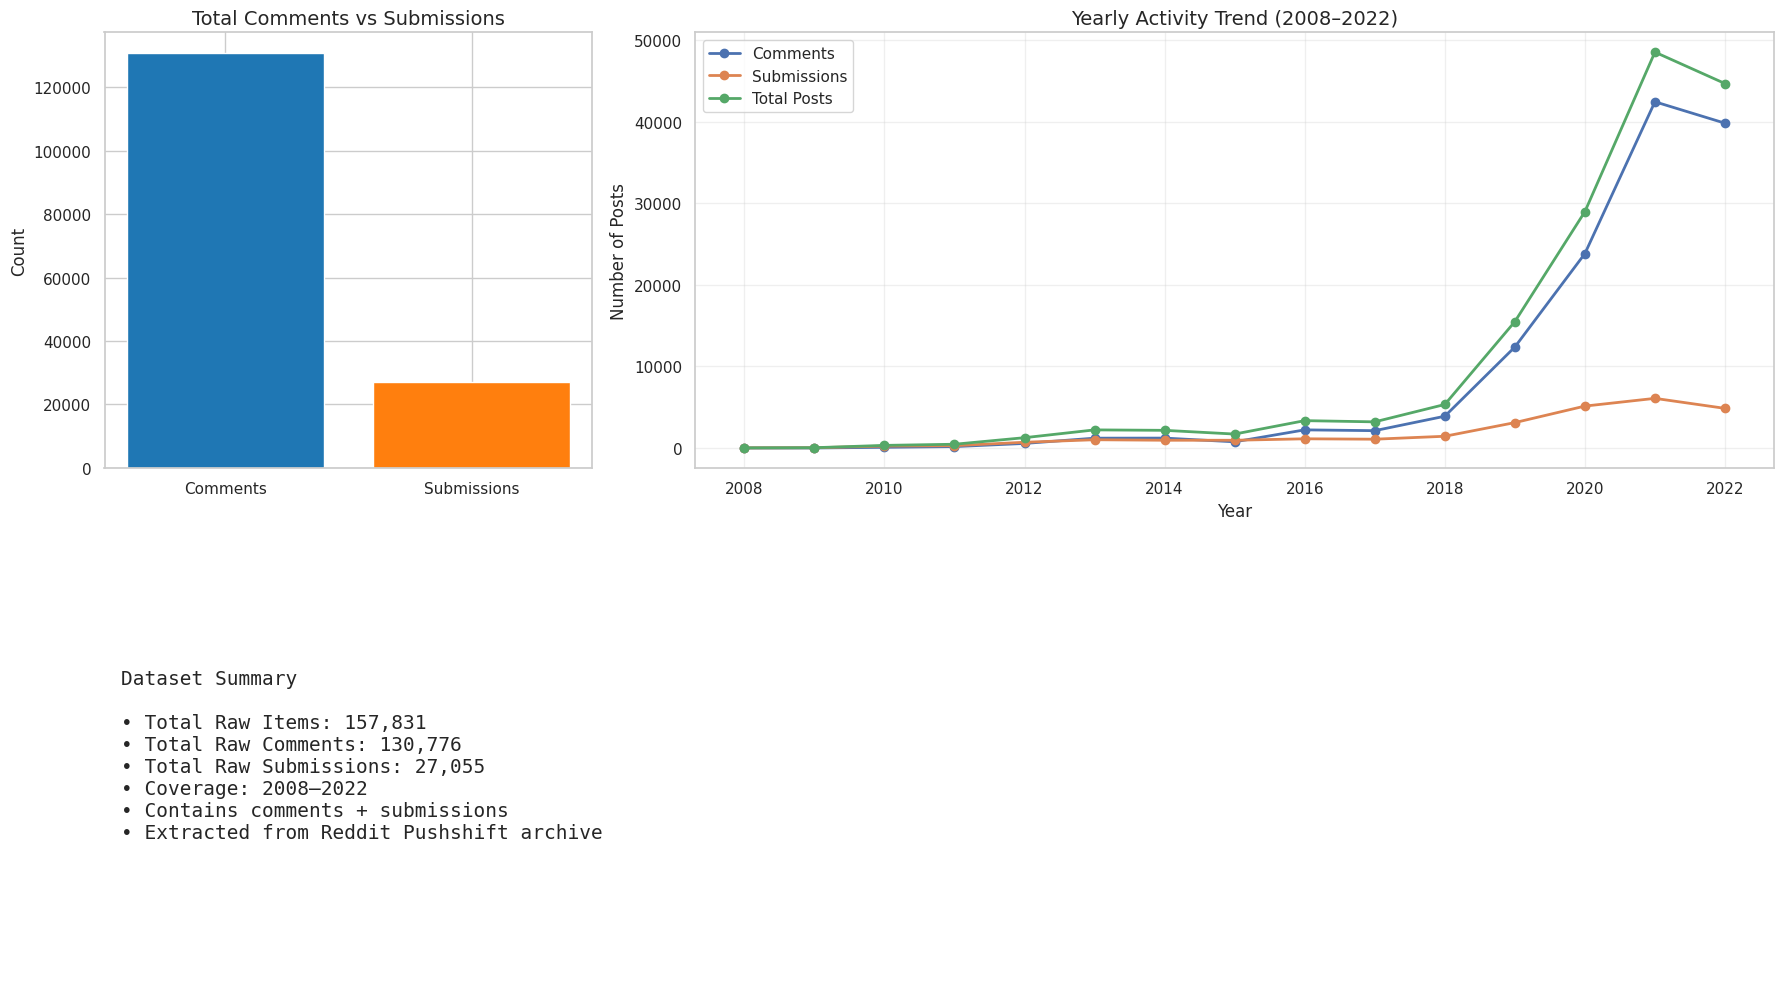

In [ ]:
# My raw data
raw_overview = {
    'Total Raw Comments': 130776,
    'Total Raw Submissions': 27055,
    'Total Raw Items': 157831
}

# Raw yearly table shared
data = {
    'year': [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022],
    'comment': [2,6,86,175,561,1208,1216,760,2226,2127,3897,12383,23840,42457,39832],
    'submission': [16,33,236,288,706,1015,952,951,1130,1081,1441,3114,5141,6089,4862],
}

df = pd.DataFrame(data)
df["total"] = df["comment"] + df["submission"]

sns.set(style="whitegrid")
fig = plt.figure(figsize=(18, 10))

# Panel A: Total Counts 
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax1.bar(["Comments", "Submissions"],
        [raw_overview['Total Raw Comments'], raw_overview['Total Raw Submissions']],
        color=["#1f77b4", "#ff7f0e"])
ax1.set_title("Total Comments vs Submissions", fontsize=14)
ax1.set_ylabel("Count")

# Panel B: Yearly Trends
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2)
ax2.plot(df["year"], df["comment"], marker="o", label="Comments", linewidth=2)
ax2.plot(df["year"], df["submission"], marker="o", label="Submissions", linewidth=2)
ax2.plot(df["year"], df["total"], marker="o", label="Total Posts", linewidth=2)
ax2.set_title("Yearly Activity Trend (2008–2022)", fontsize=14)
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of Posts")
ax2.legend()
ax2.grid(alpha=0.3)

# Panel C: Dataset Info Card 
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=3)
ax3.axis("off")

summary_text = (
    f"Dataset Summary\n"
    f"\n• Total Raw Items: {raw_overview['Total Raw Items']:,}"
    f"\n• Total Raw Comments: {raw_overview['Total Raw Comments']:,}"
    f"\n• Total Raw Submissions: {raw_overview['Total Raw Submissions']:,}"
    f"\n• Coverage: 2008–2022"
    f"\n• Contains comments + submissions"
    f"\n• Extracted from Reddit Pushshift archive"
)

ax3.text(0.01, 0.5, summary_text, fontsize=14, family="monospace", va="center")

plt.tight_layout()
plt.show()


In the cell Below
- Setting one main folder where all my input and output files will be stored.  
- Loading two input files: sustainability comments and submissions in .zst format.  
- Creating two output folders where I will save the filtered Parquet files.  
- Making sure the folders exist by creating them if they are missing.  
- Setting the start year and end year for my data (2008 to 2022) and printing my file paths to confirm everything is correct.


In [ ]:
# I set a base folder where I keep inputs and outputs in my Drive.
BASE = "/content/drive/MyDrive/Colab Notebooks"

# Input files I already uploaded
COMMENTS_ZST    = f"{BASE}/sustainability_comments.zst"
SUBMISSIONS_ZST = f"{BASE}/sustainability_submissions.zst"

# Output folders for filtered Parquet (one folder for comments, one for submissions)
OUT_BASE = f"/content/drive/MyDrive/r_sustainability"
OUT_RC   = f"{OUT_BASE}/RC"   # comments per-year parquet
OUT_RS   = f"{OUT_BASE}/RS"   # submissions per-year parquet

os.makedirs(OUT_RC, exist_ok=True)
os.makedirs(OUT_RS, exist_ok=True)

START_YEAR, END_YEAR = 2008, 2022
print("Inputs set.\nComments:", COMMENTS_ZST, "\nSubmissions:", SUBMISSIONS_ZST)
print("Outputs will go to:", OUT_BASE)

Inputs set.
Comments: /content/drive/MyDrive/Colab Notebooks/sustainability_comments.zst 
Submissions: /content/drive/MyDrive/Colab Notebooks/sustainability_submissions.zst
Outputs will go to: /content/drive/MyDrive/r_sustainability


# File Validation and Inspection

-  Creating a small function that converts file size into KB/MB/GB in a simple readable form.  
-  Looping through my two input files to check if they exist in my Drive.  
-  Getting each file’s size and last modified time if it exists.  
-  Printing a clear status message (OK or MISSING) for each file with size and timestamp.


In [ ]:
def human(n):
    units = ["B","KB","MB","GB","TB"]
    i = 0
    while n >= 1024 and i < len(units)-1:
        n /= 1024; i += 1
    return f"{n:.2f} {units[i]}"

for p in [COMMENTS_ZST, SUBMISSIONS_ZST]:
    ok = os.path.exists(p)
    size = human(os.path.getsize(p)) if ok else "missing"
    tm = time.ctime(os.path.getmtime(p)) if ok else "-"
    print(f"{'OK' if ok else 'MISSING'} — {p}\n  size={size}  modified={tm}")

OK — /content/drive/MyDrive/Colab Notebooks/sustainability_comments.zst
  size=18.62 MB  modified=Tue Sep 30 01:34:29 2025
OK — /content/drive/MyDrive/Colab Notebooks/sustainability_submissions.zst
  size=8.00 MB  modified=Tue Sep 30 01:34:24 2025


- listing the paths of the two .zst files that I want to inspect.  
- printing each file’s size to confirm the file is correctly uploaded.  
- reading the first 4 bytes of each file to check if it matches the Zstandard magic header.  
- also reading the first 200 bytes to detect if the file is accidentally an HTML file.  
- printing warnings if the file is not a real Zstandard dump or if the header does not match the expected magic bytes.


In [ ]:
paths = [
  "/content/drive/MyDrive/Colab Notebooks/sustainability_comments.zst",
  "/content/drive/MyDrive/Colab Notebooks/sustainability_submissions.zst"
]

for p in paths:
    print("File:", p, "size:", os.path.getsize(p))
    with open(p, "rb") as f:
        head = f.read(4)
        print("  First 4 bytes (hex):", head.hex())
        f.seek(0)
        first_200 = f.read(200)
        if b"<!DOCTYPE html" in first_200 or b"<html" in first_200.lower():
            print("  ⚠ Looks like HTML, not a .zst dump.")
        if head != b'\x28\xb5\x2f\xfd':  # Zstandard magic bytes
            print("  ⚠ Not a valid Zstandard stream (wrong file).")

File: /content/drive/MyDrive/Colab Notebooks/sustainability_comments.zst size: 19522184
  First 4 bytes (hex): 28b52ffd
File: /content/drive/MyDrive/Colab Notebooks/sustainability_submissions.zst size: 8391451
  First 4 bytes (hex): 28b52ffd


## Previewing a few JSON lines (sanity check)

- Creating a function that opens a .zst file and previews the first few JSON lines.  
- Decompressing the file using a streaming reader so it does not load everything into memory.  
- Printing the keys of each JSON object to understand the structure of the data.  
- Printing a short text sample (body, selftext, or title) from each line to quickly check the content.


In [ ]:
def preview_zst(path, n=5):
    print(">>>", path)
    with open(path, "rb") as f:
        dctx = zstd.ZstdDecompressor()
        with dctx.stream_reader(f) as r, io.TextIOWrapper(r, encoding="utf-8", errors="ignore") as text:
            for i in range(n):
                line = next(text)
                obj = json.loads(line)
                keys = list(obj.keys())
                print(f"\nLine {i+1} keys ({len(keys)}): {keys[:12]} ...")
                sample = (obj.get("body") or obj.get("selftext") or obj.get("title") or "")[:140].replace("\n"," ")
                print(" sample:", sample)

preview_zst("/content/drive/MyDrive/Colab Notebooks/sustainability_comments.zst", n=3)
preview_zst("/content/drive/MyDrive/Colab Notebooks/sustainability_submissions.zst", n=3)

>>> /content/drive/MyDrive/Colab Notebooks/sustainability_comments.zst

Line 1 keys (21): ['link_id', 'created_utc', 'distinguished', 'edited', 'id', 'archived', 'name', 'author', 'ups', 'score_hidden', 'controversiality', 'body'] ...
 I strongly recommend wa

Line 2 keys (21): ['author', 'ups', 'score_hidden', 'subreddit_id', 'body', 'downs', 'retrieved_on', 'parent_id', 'created_utc', 'author_flair_text', 'distinguished', 'link_id'] ...
 sample: Could you put in [video] for these. 

Line 3 keys (21): ['controversiality', 'subreddit_id', 'score', 'author_flair_text', 'retrieved_on', 'id', 'subreddit', 'name', 'body', 'author_flair_css_class', 'archived', 'link_id'] ...
 sample: 'The gift economy and the sustainable community... In my work, I offer all of my services as a gift to my community. I assign no financial v
>>> /content/drive/MyDrive/Colab Notebooks/sustainability_submissions.zst

Line 1 keys (55): ['archived', 'author', 'author_flair_background_color', 'author_flair_css_clas

# Create per-year Parquet for comments and submissions

 (Will run once and then comment it as we dont need to do this each time)
 and here,

- Setting the input path for the comments .zst file and creating an output folder for yearly Parquet files.  
- Defining helper functions to extract the year from each timestamp and to save each yearly chunk safely.  
- Reading the .zst file line by line and converting each JSON line into a Python object.  
- Filtering the data so that only r/sustainability comments between 2008 and 2022 are kept.  
- Storing comments in per-year buffers and writing them to Parquet files in small parts to save RAM.  
- Finally flushing all buffers, writing the remaining data, and printing how many comments I saved overall.


In [ ]:
'''
RC_IN   = "/content/drive/MyDrive/Colab Notebooks/sustainability_comments.zst"
OUT_RC  = "/content/drive/MyDrive/r_sustainability/RC"
os.makedirs(OUT_RC, exist_ok=True)

START_YEAR, END_YEAR = 2008, 2022

def yfrom(ts):
    try:
        return datetime.fromtimestamp(int(ts), tz=timezone.utc).year
    except Exception:
        return None

def write_year_chunk(df, year, part, out_dir, prefix="RC"):
    # Enforce clean dtypes before writing
    if "created_utc" in df:
        df["created_utc"] = pd.to_numeric(df["created_utc"], errors="coerce").fillna(0).astype("int64")
        # also add a timezone-aware datetime for convenience
        df["created_dt"] = pd.to_datetime(df["created_utc"], unit="s", utc=True)
    for c in ("score",):
        if c in df:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int64")
    for c in ("id","author","link_id","parent_id","body","kind"):
        if c in df:
            df[c] = df[c].astype("string")

    out = f"{out_dir}/{prefix}_{year}_part{part}.parquet"
    df.to_parquet(out, index=False)
    return out

def stream_comments_to_year_parquet(zst_path, out_dir, start_year, end_year, flush_every=200_000):
    kept_total = 0
    buffers = {y: [] for y in range(start_year, end_year+1)}
    parts   = {y: 0  for y in range(start_year, end_year+1)}

    with open(zst_path, "rb") as f:
        dctx = zstd.ZstdDecompressor()
        with dctx.stream_reader(f) as r, io.TextIOWrapper(r, encoding="utf-8", errors="ignore") as text:
            for line in text:
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError:
                    continue

                # only r/sustainability
                if (obj.get("subreddit") or "").lower() != "sustainability":
                    continue

                ts = obj.get("created_utc")
                y  = yfrom(ts)
                if y is None or y < start_year or y > end_year:
                    continue

                # build the row with safe defaults (strings for text fields)
                buffers[y].append({
                    "kind": "comment",
                    "id": obj.get("id"),
                    "created_utc": obj.get("created_utc"),
                    "author": obj.get("author"),
                    "body": obj.get("body") if isinstance(obj.get("body"), str) else "",
                    "score": obj.get("score"),
                    "link_id": obj.get("link_id"),
                    "parent_id": obj.get("parent_id"),
                })
                kept_total += 1

                # flush per-year buffer to keep RAM low
                if len(buffers[y]) >= flush_every:
                    df = pd.DataFrame(buffers[y]); buffers[y] = []
                    out = write_year_chunk(df, y, parts[y], out_dir, prefix="RC")
                    parts[y] += 1
                    print(" wrote", out, f"(running total: {kept_total:,})")

    # final flush
    for y in range(start_year, end_year+1):
        if buffers[y]:
            df = pd.DataFrame(buffers[y]); buffers[y] = []
            out = write_year_chunk(df, y, parts[y], out_dir, prefix="RC")
            parts[y] += 1
            print(" wrote", out)

    print(f"\nDONE — saved ≈{kept_total:,} comments to {out_dir}")

# Run it (once)
stream_comments_to_year_parquet(RC_IN, OUT_RC, START_YEAR, END_YEAR)'''

'\nRC_IN   = "/content/drive/MyDrive/Colab Notebooks/sustainability_comments.zst"\nOUT_RC  = "/content/drive/MyDrive/r_sustainability/RC"\nos.makedirs(OUT_RC, exist_ok=True)\n\nSTART_YEAR, END_YEAR = 2008, 2022\n\ndef yfrom(ts):\n    try:\n        return datetime.fromtimestamp(int(ts), tz=timezone.utc).year\n    except Exception:\n        return None\n\ndef write_year_chunk(df, year, part, out_dir, prefix="RC"):\n    # Enforce clean dtypes before writing\n    if "created_utc" in df:\n        df["created_utc"] = pd.to_numeric(df["created_utc"], errors="coerce").fillna(0).astype("int64")\n        # also add a timezone-aware datetime for convenience\n        df["created_dt"] = pd.to_datetime(df["created_utc"], unit="s", utc=True)\n    for c in ("score",):\n        if c in df:\n            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int64")\n    for c in ("id","author","link_id","parent_id","body","kind"):\n        if c in df:\n            df[c] = df[c].astype("string")

# Convert Raw ZST Dumps → Yearly Parquet Files

 - Setting the input path for the submissions data and creating an output folder for the processed yearly files.  
- Defining helper functions to extract the year from timestamps and to write each year’s data safely with correct data types.  
- Reading the submissions .zst file line by line, converting each JSON record into a Python object.  
- Filtering the data to keep only r/sustainability submissions between 2008 and 2022.  
- Storing submissions in per-year buffers and writing them out in smaller chunks to control memory usage.  
- Flushing all remaining data at the end and printing how many submissions were successfully saved.


In [ ]:
# Now running once for Submissions

'''
RS_IN   = "/content/drive/MyDrive/Colab Notebooks/sustainability_submissions.zst"
OUT_RS  = "/content/drive/MyDrive/r_sustainability/RS"
os.makedirs(OUT_RS, exist_ok=True)

START_YEAR, END_YEAR = 2008, 2022

def yfrom(ts):
    try:
        return datetime.fromtimestamp(int(ts), tz=timezone.utc).year
    except Exception:
        return None

def write_year_chunk(df, year, part, out_dir, prefix="RS"):
    if "created_utc" in df:
        df["created_utc"] = pd.to_numeric(df["created_utc"], errors="coerce").fillna(0).astype("int64")
        df["created_dt"]  = pd.to_datetime(df["created_utc"], unit="s", utc=True)
    for c in ("score","num_comments"):
        if c in df:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int64")
    for c in ("id","author","title","selftext","permalink","kind"):
        if c in df:
            df[c] = df[c].astype("string")

    out = f"{out_dir}/{prefix}_{year}_part{part}.parquet"
    df.to_parquet(out, index=False)
    return out

def stream_submissions_to_year_parquet(zst_path, out_dir, start_year, end_year, flush_every=100_000):
    kept_total = 0
    buffers = {y: [] for y in range(start_year, end_year+1)}
    parts   = {y: 0  for y in range(start_year, end_year+1)}

    with open(zst_path, "rb") as f:
        dctx = zstd.ZstdDecompressor()
        with dctx.stream_reader(f) as r, io.TextIOWrapper(r, encoding="utf-8", errors="ignore") as text:
            for line in text:
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError:
                    continue

                if (obj.get("subreddit") or "").lower() != "sustainability":
                    continue

                y = yfrom(obj.get("created_utc"))
                if y is None or y < start_year or y > end_year:
                    continue

                buffers[y].append({
                    "kind":"submission",
                    "id": obj.get("id"),
                    "created_utc": obj.get("created_utc"),
                    "author": obj.get("author"),
                    "title": obj.get("title") if isinstance(obj.get("title"), str) else "",
                    "selftext": obj.get("selftext") if isinstance(obj.get("selftext"), str) else "",
                    "score": obj.get("score"),
                    "num_comments": obj.get("num_comments"),
                    "permalink": obj.get("permalink"),
                })
                kept_total += 1

                if len(buffers[y]) >= flush_every:
                    df = pd.DataFrame(buffers[y]); buffers[y] = []
                    out = write_year_chunk(df, y, parts[y], out_dir, prefix="RS")
                    parts[y] += 1
                    print(" wrote", out, f"(running total: {kept_total:,})")

    for y in range(start_year, end_year+1):
        if buffers[y]:
            df = pd.DataFrame(buffers[y]); buffers[y] = []
            out = write_year_chunk(df, y, parts[y], out_dir, prefix="RS")
            parts[y] += 1
            print(" wrote", out)

    print(f"\nDONE — saved ≈{kept_total:,} submissions to {out_dir}")

stream_submissions_to_year_parquet(RS_IN, OUT_RS, START_YEAR, END_YEAR)'''


'\nRS_IN   = "/content/drive/MyDrive/Colab Notebooks/sustainability_submissions.zst"\nOUT_RS  = "/content/drive/MyDrive/r_sustainability/RS"\nos.makedirs(OUT_RS, exist_ok=True)\n\nSTART_YEAR, END_YEAR = 2008, 2022\n\ndef yfrom(ts):\n    try:\n        return datetime.fromtimestamp(int(ts), tz=timezone.utc).year\n    except Exception:\n        return None\n\ndef write_year_chunk(df, year, part, out_dir, prefix="RS"):\n    if "created_utc" in df:\n        df["created_utc"] = pd.to_numeric(df["created_utc"], errors="coerce").fillna(0).astype("int64")\n        df["created_dt"]  = pd.to_datetime(df["created_utc"], unit="s", utc=True)\n    for c in ("score","num_comments"):\n        if c in df:\n            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int64")\n    for c in ("id","author","title","selftext","permalink","kind"):\n        if c in df:\n            df[c] = df[c].astype("string")\n\n    out = f"{out_dir}/{prefix}_{year}_part{part}.parquet"\n    df.to_parquet(out,

# Load Per-Year Parquet Files & Build Unified Dataset

**What doing now**
1. Load all **comments (RC_*.parquet)** and **submissions (RS_*.parquet)** from Drive.
2. Create a unified `text` column:
   - comments → `body`
   - submissions → `title + " " + selftext`
3. Keep datetime (`created_dt`) and make a `month` key (YYYY-MM).
4. Print **totals** (overall + by kind + by year) and show a few **full sentences** so I can see what the raw text looks like.


## Load all Parquet & build text column

In [ ]:
RC_DIR = "/content/drive/MyDrive/r_sustainability/RC"
RS_DIR = "/content/drive/MyDrive/r_sustainability/RS"

rc_files = sorted(glob.glob(f"{RC_DIR}/RC_*.parquet"))
rs_files = sorted(glob.glob(f"{RS_DIR}/RS_*.parquet"))

# I load only needed columns for speed.
use_rc_cols = ["kind","id","created_utc","created_dt","author","body","score","link_id","parent_id"]
use_rs_cols = ["kind","id","created_utc","created_dt","author","title","selftext","score","num_comments","permalink"]

rc_list = [pd.read_parquet(p, columns=[c for c in use_rc_cols if c in pd.read_parquet(p).columns]) for p in rc_files]
rs_list = [pd.read_parquet(p, columns=[c for c in use_rs_cols if c in pd.read_parquet(p).columns]) for p in rs_files]

rc = pd.concat(rc_list, ignore_index=True) if rc_list else pd.DataFrame(columns=use_rc_cols)
rs = pd.concat(rs_list, ignore_index=True) if rs_list else pd.DataFrame(columns=use_rs_cols)

# I standardise `text`
rc["text"] = rc["body"].fillna("")
rs["text"] = (rs.get("title","").fillna("") + " " + rs.get("selftext","").fillna("")).str.strip()

# I keep a minimal, consistent schema
keep_rc = ["kind","id","created_utc","created_dt","author","text","score","link_id","parent_id"]
keep_rs = ["kind","id","created_utc","created_dt","author","text","score","num_comments","permalink"]

rc = rc[[c for c in keep_rc if c in rc.columns]]
rs = rs[[c for c in keep_rs if c in rs.columns]]

import numpy as np
for df in (rc, rs):
    df["created_dt"] = pd.to_datetime(df["created_dt"], utc=True)
    df["month"] = df["created_dt"].dt.to_period("M").astype(str)
    # Ensure text is string
    df["text"] = df["text"].astype(str)

# I combine comments + submissions for "whole subreddit" analysis
df_all = pd.concat([rc, rs], ignore_index=True, sort=False)

len(rc), len(rs), len(df_all)

(130776, 27055, 157831)

## Totals, by-year table, and sample sentences




- Defining a small function that takes a dataframe and counts how many items appear in each year.  
- Checking the total number of comments, submissions, and combined items after all preprocessing.  
- Generating year-wise summary tables for comments, submissions, and all items together.  
- Displaying these tables to understand the yearly distribution of my dataset.  



In [ ]:
def counts_by_year(df, label):
    tmp = df.copy()
    tmp["year"] = tmp["created_dt"].dt.year
    table = tmp.groupby("year").size().reset_index(name=f"{label}_count")
    return table
print("Total comments:", len(rc))
print("Total submissions:", len(rs))
print("Total ALL:", len(df_all))

# By year
rc_year = counts_by_year(rc, "comments")
rs_year = counts_by_year(rs, "submissions")
all_year = counts_by_year(df_all, "all_items")

display(rc_year)
display(rs_year)
display(all_year)

# I also print a few full sentences to see the style of text
print("\n=== Sample comments ===")
for _, row in rc.sample(min(5, len(rc)), random_state=1).iterrows():
    print(f"- [{row['created_dt']:%Y-%m-%d}] {row['text'][:300]}")

print("\n=== Sample submissions (title+selftext) ===")
for _, row in rs.sample(min(5, len(rs)), random_state=1).iterrows():
    print(f"- [{row['created_dt']:%Y-%m-%d}] {row['text'][:300]}")

Total comments: 130776
Total submissions: 27055
Total ALL: 157831


year  comments_count
0   2008               2
1   2009               6
2   2010              86
3   2011             175
4   2012             561
5   2013            1208
6   2014            1216
7   2015             760
8   2016            2226
9   2017            2127
10  2018            3897
11  2019           12383
12  2020           23840
13  2021           42457
14  2022           39832

year  submissions_count
0   2008                 16
1   2009                 33
2   2010                236
3   2011                288
4   2012                706
5   2013               1015
6   2014                952
7   2015                951
8   2016               1130
9   2017               1081
10  2018               1441
11  2019               3114
12  2020               5141
13  2021               6089
14  2022               4862

year  all_items_count
0   2008               18
1   2009               39
2   2010              322
3   2011              463
4   2012             1267
5   2013             2223
6   2014             2168
7   2015             1711
8   2016             3356
9   2017             3208
10  2018             5338
11  2019            15497
12  2020            28981
13  2021            48546
14  2022            44694


=== Sample comments ===
- [2021-04-12] Tbh, I am extremely privileged in terms of socio-economic class. Many others don't have a choice. I say what I said to illustrate how it affects one individual, imagine that for a whole population. For example toxic e-waste dumped unto poorer nations, according to [the UN report](https://ourworld.un
- [2021-05-30] I second the Hey Humans brand! Fluoride toothpaste that is eco friendly is hard to find in my experience.
- [2014-03-27] What makes me less worried is remembering that we are just a bunch of evolved talking monkeys, on a small "rock" floating in a universe so vast our minds have trouble grasping the size....  

I just make sure I'm doing everything I can to help the environment
- [2022-10-14] Focus on urban design and transportation infrastructure, as well as regional planning.  The underlying system we live in and do our daily lives must also be part.
- [2020-05-27] That’s so funny, I just finished watching Sean Carroll’s livestream on

# Text Cleaning

## Cleaning plan (simple & conservative)

- Lowercase, remove URLs, replace emojis with space, normalise whitespace.
- Drop obvious placeholders: "[removed]" and "[deleted]".
- **No minimum length filter** (as I decided).
- Save a **clean** copy of comments/submissions merged for analysis.

Will keep a counter of how many placeholders I removed (useful for Methods).


## **Clean text (no min length), track removals, save cleaned Parquet**

In [ ]:
'''
def clean_text(t: str) -> str:
    t = t.lower()
    # remove URLs
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    # replace emojis with space so words don't glue
    t = emoji.replace_emoji(t, replace=" ")
    # collapse whitespace
    t = re.sub(r"\s+", " ", t).strip()
    return t

# count placeholders before cleaning
placeholders = df_all["text"].str.strip().str.lower().isin(["[removed]", "[deleted]"]).sum()
print("Placeholders to drop:", placeholders)

df_all_clean = df_all[~df_all["text"].str.strip().str.lower().isin(["[removed]", "[deleted]"])].copy()
df_all_clean["text"] = df_all_clean["text"].apply(clean_text)

print("Rows after cleaning:", len(df_all_clean))

# Save a single cleaned parquet for faster reloads next time
CLEAN_PATH = "/content/drive/MyDrive/r_sustainability/ALL_clean.parquet"
df_all_clean.to_parquet(CLEAN_PATH, index=False)
print("Saved cleaned file to:", CLEAN_PATH)'''

<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2146762689.py:5: SyntaxWarning: invalid escape sequence '\S'
  t = re.sub(r"http\S+|www\.\S+", " ", t)


'\ndef clean_text(t: str) -> str:\n    t = t.lower()\n    # remove URLs\n    t = re.sub(r"http\\S+|www\\.\\S+", " ", t)\n    # replace emojis with space so words don\'t glue\n    t = emoji.replace_emoji(t, replace=" ")\n    # collapse whitespace\n    t = re.sub(r"\\s+", " ", t).strip()\n    return t\n\n# count placeholders before cleaning\nplaceholders = df_all["text"].str.strip().str.lower().isin(["[removed]", "[deleted]"]).sum()\nprint("Placeholders to drop:", placeholders)\n\ndf_all_clean = df_all[~df_all["text"].str.strip().str.lower().isin(["[removed]", "[deleted]"])].copy()\ndf_all_clean["text"] = df_all_clean["text"].apply(clean_text)\n\nprint("Rows after cleaning:", len(df_all_clean))\n\n# Save a single cleaned parquet for faster reloads next time\nCLEAN_PATH = "/content/drive/MyDrive/r_sustainability/ALL_clean.parquet"\ndf_all_clean.to_parquet(CLEAN_PATH, index=False)\nprint("Saved cleaned file to:", CLEAN_PATH)'

**Reloading the already-cleaned dataset**

In [ ]:
#  Reloading the already-cleaned dataset
CLEAN_PATH = "/content/drive/MyDrive/r_sustainability/ALL_clean.parquet"
df_all_clean = pd.read_parquet(CLEAN_PATH)
print("Reloaded cleaned data:", len(df_all_clean), "rows")

Reloaded cleaned data: 148578 rows


# Quick EDA
- totals after cleaning, top tokens (just to sanity-check)

This is just to see if anything weird dominates (e.g., “the” or “like”)  I will handle stopwords inside BERTopic via its vectorizer

In [ ]:
print("Cleaned totals (ALL):", len(df_all_clean))
print("By kind:")
print(df_all_clean["kind"].value_counts())

# crude bag-of-words for a quick feeling (no stemming/stopword removal yet)
tok = re.compile(r"[a-z]{3,}")  # rough word tokens (3+ letters)
counts = Counter()
for t in df_all_clean["text"].head(200_000):  # sample for speed
    counts.update(tok.findall(t))

print("\nTop 30 tokens (rough):")
for w, c in counts.most_common(30):
    print(f"{w:>15}  {c}")

Cleaned totals (ALL): 148578
By kind:
kind
comment       121523
submission     27055
Name: count, dtype: Int64

Top 30 tokens (rough):
            the  281112
            and  178868
           that  108774
            you  93613
            for  84032
            are  61575
            but  51727
           this  49473
           have  47855
            not  47327
           with  43267
            can  41870
           they  40785
           more  33907
           from  28872
         people  27743
           your  27483
           just  26810
           like  26751
           what  26337
          about  25950
          there  25927
            all  25381
          would  24485
           will  22158
            don  21069
            how  19204
          their  18940
            one  18190
           them  18073


# Topic discovery on the **full** r/sustainability corpus (no sampling)


- Want the model to “see” *all* discussions so rare but important themes are not missed.
- Will **encode all texts** to embeddings in **batches**, write them to a **disk-backed NumPy memmap** (so I don’t run out of RAM), then fit BERTopic on those embeddings.

**Core steps**
1) Reload my cleaned data (`ALL_clean.parquet`).
2) Build **embeddings for every row** (batched) → store in a **memmap** on Drive.
3) Configure BERTopic with a **good vectorizer** (stopwords removed, 2–3-gram phrases, sensible `min_df`/`max_df`).
4) Fit BERTopic **on the full corpus** (pass the full texts + memmapped embeddings).
5) Inspect topics, reduce/merge if needed, name them, and save:
   - topics per row
   - topic metadata (size, keywords, representative docs)
6) Small quality checks: outlier rate (topic = −1), overlap, uniqueness of top terms.


Reloading cleaned data

In [ ]:
CLEAN_PATH = "/content/drive/MyDrive/r_sustainability/ALL_clean.parquet"
df = pd.read_parquet(CLEAN_PATH)

# I keep only what I need for topics + later joins
df = df[["id","created_dt","month","kind","text"]].copy()
print("Rows loaded:", len(df))
df.head(2)

Rows loaded: 148578


id                created_dt    month     kind  \
0  c053uiv 2008-08-20 10:30:13+00:00  2008-08  comment   
1  c05rm75 2008-10-08 19:53:34+00:00  2008-10  comment   

                                                text  
0  this is an excellent introduction to exponenti...  
1                could you put in [video] for these.

# Embedding Generation (SBERT)

## **Build full-corpus embeddings to a memmap**


- Choosing the `all-MiniLM-L6-v2` model because it is fast, lightweight, and good for topic modelling.  
- Creating a memory-mapped file on Google Drive to store all embeddings without filling RAM.  
- Setting the embedding size, batch size, and file path for saving the vectors.  
- Loading the SBERT model and preparing all text entries from my dataframe.  
- Computing embeddings in batches (to avoid out-of-memory errors) and writing each batch directly into the memmap file.  
- Flushing the memmap to disk and cleaning memory so the embeddings are safely saved for later clustering or BERTopic.


In [ ]:
# I will comment this cell once so I don't rebuild embeddings again as i dont need it every time

'''
EMB_MODEL_NAME = "all-MiniLM-L6-v2"   # fast & solid for topics
EMB_BATCH = 512                        # adjust if get OOM; 256/384/512 are common
EMB_DIM = 384                          # dimension of all-MiniLM-L6-v2
EMB_PATH = "/content/drive/MyDrive/r_sustainability/ALL_embeddings.memmap"

# I prepare the memmap (float32 to halve storage, it's fine for clustering)
N = len(df)
emb_mem = np.memmap(EMB_PATH, dtype="float32", mode="w+", shape=(N, EMB_DIM))

# Build embeddings in batches
sbert = SentenceTransformer(EMB_MODEL_NAME)
texts = df["text"].tolist()

for start in tqdm.tqdm(range(0, N, EMB_BATCH)):
    end = min(start + EMB_BATCH, N)
    batch = texts[start:end]
    emb = sbert.encode(batch, normalize_embeddings=True, show_progress_bar=False)
    emb_mem[start:end, :] = emb.astype("float32")
    del emb; gc.collect()

# Flush to disk
emb_mem.flush()
del emb_mem; gc.collect()

print("Saved embeddings memmap:", EMB_PATH)'''

'\nEMB_MODEL_NAME = "all-MiniLM-L6-v2"   # fast & solid for topics\nEMB_BATCH = 512                        # adjust if you get OOM; 256/384/512 are common\nEMB_DIM = 384                          # dimension of all-MiniLM-L6-v2\nEMB_PATH = "/content/drive/MyDrive/r_sustainability/ALL_embeddings.memmap"\n\n# I prepare the memmap (float32 to halve storage, it\'s fine for clustering)\nN = len(df)\nemb_mem = np.memmap(EMB_PATH, dtype="float32", mode="w+", shape=(N, EMB_DIM))\n\n# Build embeddings in batches\nsbert = SentenceTransformer(EMB_MODEL_NAME)\ntexts = df["text"].tolist()\n\nfor start in tqdm.tqdm(range(0, N, EMB_BATCH)):\n    end = min(start + EMB_BATCH, N)\n    batch = texts[start:end]\n    emb = sbert.encode(batch, normalize_embeddings=True, show_progress_bar=False)\n    emb_mem[start:end, :] = emb.astype("float32")\n    del emb; gc.collect()\n\n# Flush to disk\nemb_mem.flush()\ndel emb_mem; gc.collect()\n\nprint("Saved embeddings memmap:", EMB_PATH)'

# Duplicate Removal

## Remove near-duplicates before topics

- Using a SHA-1 hash to create a unique fingerprint for every text entry.  
- Applying this hash to each row so that identical texts produce the same hash value.  
- Removing exact duplicate items by dropping rows that have the same hash.  
- Checking how many items were removed and how many were kept after de-duplication.  
- Cleaning the dataframe by deleting the temporary hash column once the duplicates are removed.


In [ ]:
# Quick near-duplicate removal using simple hashing on normalized text
def short_hash(t: str) -> str:
    # normalize whitespace already done; I just hash the text
    return hashlib.sha1(t.encode("utf-8", errors="ignore")).hexdigest()

df["hash"] = df["text"].apply(short_hash)
before = len(df)
df = df.drop_duplicates(subset=["hash"])  # exact duplicates; for fuzzy duplicates
after = len(df)
print(f"Removed exact dupes: {before - after}  (kept {after})")
df = df.drop(columns=["hash"])

Removed exact dupes: 3522  (kept 145056)


# Topic Modeling (BERTopic)

## Configure BERTopic for full-corpus fit
- Checking how many documents I have so I can tune BERTopic parameters properly.  
- Defining a function that picks good min_df and max_df thresholds based on corpus size, so my vectorizer works well for big or small datasets.  
- Calculating the actual document counts that these thresholds represent and printing them for my logs/report.  
- Creating a CountVectorizer that uses bigrams and trigrams, removes English stopwords, and applies the adaptive thresholds.  
- Setting up KeyBERTInspired as my representation model to produce cleaner topic labels.  
- Configuring BERTopic with a high minimum topic size for stability and giving it my custom vectorizer and representation model.  
- Printing the final configuration to confirm everything is set correctly before fitting the model.


In [ ]:
'''
# Corpus size that will be used to FIT (full corpus in this case)
N_docs = len(df)
print("Fitting topics on full corpus. N_docs =", N_docs)

# Pick proportional thresholds that scale with N and always satisfy min_df < max_df
def pick_thresholds(n):
    # min_df: how rare terms we keep (lower keeps rarer phrases)
    # max_df: how common terms we drop (higher keeps more frequent phrases)
    if n >= 1_000_000:
        min_df = 0.0005   # 0.05%
        max_df = 0.40
    elif n >= 200_000:
        min_df = 0.001    # 0.1%
        max_df = 0.45
    elif n >= 50_000:
        min_df = 0.002    # 0.2%
        max_df = 0.50
    else:
        min_df = 0.005    # 0.5% for small corpora
        max_df = 0.60
    # Safety: ensure min_df < max_df
    if min_df >= max_df:
        min_df = max_df / 2.0
    return min_df, max_df

min_df_prop, max_df_prop = pick_thresholds(N_docs)

# Show the actual doc-count cutoffs these imply (just for the log / report)
min_docs = max(1, int(min_df_prop * N_docs))
max_docs = max(1, int(max_df_prop * N_docs))
print(f"Vectorizer thresholds → min_df={min_df_prop:.4f} (~{min_docs} docs), "
      f"max_df={max_df_prop:.2f} (~{max_docs} docs)")

# Vectorizer: bigrams/trigrams + English stopwords
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(2, 3),
    min_df=min_df_prop,   # proportions (safe, scale with N)
    max_df=max_df_prop
)

rep_model = KeyBERTInspired()

# Topic size: keep it reasonably high for stability on full corpus
MIN_TOPIC_SIZE = 1000
topic_model = BERTopic(
    min_topic_size=MIN_TOPIC_SIZE,
    vectorizer_model=vectorizer_model,
    representation_model=rep_model,
    top_n_words=10,
    calculate_probabilities=False,
    verbose=True
)
print("Configured BERTopic with min_topic_size =", MIN_TOPIC_SIZE)'''

'\n# Corpus size that will be used to FIT (full corpus in this case)\nN_docs = len(df)\nprint("Fitting topics on full corpus. N_docs =", N_docs)\n\n# Pick proportional thresholds that scale with N and always satisfy min_df < max_df\ndef pick_thresholds(n):\n    # min_df: how rare terms we keep (lower keeps rarer phrases)\n    # max_df: how common terms we drop (higher keeps more frequent phrases)\n    if n >= 1_000_000:\n        min_df = 0.0005   # 0.05%\n        max_df = 0.40\n    elif n >= 200_000:\n        min_df = 0.001    # 0.1%\n        max_df = 0.45\n    elif n >= 50_000:\n        min_df = 0.002    # 0.2%\n        max_df = 0.50\n    else:\n        min_df = 0.005    # 0.5% for small corpora\n        max_df = 0.60\n    # Safety: ensure min_df < max_df\n    if min_df >= max_df:\n        min_df = max_df / 2.0\n    return min_df, max_df\n\nmin_df_prop, max_df_prop = pick_thresholds(N_docs)\n\n# Show the actual doc-count cutoffs these imply (just for the log / report)\nmin_docs = max(

# Topic Modeling (BERTopic)

- Checking how many documents are in my dataset so I can adjust vectorizer thresholds properly.  
- Using a helper function to automatically choose suitable `min_df` and `max_df` values based on the size of my corpus.  
- Printing the actual document counts that correspond to these thresholds to understand what the vectorizer will keep or drop.  
- Creating a RAM-friendly CountVectorizer by using only bigrams and limiting the maximum number of features.  
- Setting KeyBERTInspired as my representation model to generate clearer topic labels.  
- Configuring BERTopic with a high `min_topic_size` to reduce noise and save memory during clustering.  
- Printing the final configuration to confirm the model settings before I run the topic fitting step.


In [ ]:
# Corpus size used for FIT (full corpus)
N_docs = len(df)
print("Fitting topics on full corpus. N_docs =", N_docs)

def pick_thresholds(n):
    # Proportional thresholds that always satisfy min_df < max_df
    if n >= 1_000_000:
        min_df = 0.0005   # 0.05%
        max_df = 0.40
    elif n >= 200_000:
        min_df = 0.001    # 0.1%
        max_df = 0.45
    elif n >= 50_000:
        min_df = 0.002    # 0.2%
        max_df = 0.50
    else:
        min_df = 0.005    # 0.5%
        max_df = 0.60
    if min_df >= max_df:
        min_df = max_df / 2.0
    return min_df, max_df

min_df_prop, max_df_prop = pick_thresholds(N_docs)

#  RAM savers:
#  - ngram_range=(2,2) (bigrams only for first run)
#  - max_features cap keeps c-TF-IDF matrix small enough for Colab
MAX_FEATS = 120_000   # if OOM persists, try 80_000 or 60_000

min_docs = max(1, int(min_df_prop * N_docs))
max_docs = max(1, int(max_df_prop * N_docs))
print(f"Vectorizer thresholds -> min_df={min_df_prop:.4f} (~{min_docs} docs), "
      f"max_df={max_df_prop:.2f} (~{max_docs} docs), max_features={MAX_FEATS}")

vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(2, 2),      # start with bigrams only
    min_df=min_df_prop,
    max_df=max_df_prop,
    max_features=MAX_FEATS
)

rep_model = KeyBERTInspired()

# Larger min_topic_size = fewer/noisier clusters -> less RAM in representation
MIN_TOPIC_SIZE = 1200
topic_model = BERTopic(
    min_topic_size=MIN_TOPIC_SIZE,
    vectorizer_model=vectorizer_model,
    representation_model=rep_model,
    top_n_words=10,
    calculate_probabilities=False,
    verbose=True
)
print("Configured BERTopic with min_topic_size =", MIN_TOPIC_SIZE)

Fitting topics on full corpus. N_docs = 145056
Vectorizer thresholds -> min_df=0.0020 (~290 docs), max_df=0.50 (~72528 docs), max_features=120000
Configured BERTopic with min_topic_size = 1200


## **Fit BERTopic on all texts using the memmap embeddings**


- Loading my cleaned dataset and checking how many documents I will be modelling.  
- Opening the precomputed embedding memmap file so I can run BERTopic without recomputing embeddings again.  
- Choosing safe `min_df` and `max_df` thresholds and building a RAM-friendly CountVectorizer (bigrams only + max_features cap).  
- Loading the same SBERT model I used earlier, so the representation step uses consistent embeddings.  
- Creating a BERTopic model, with fallback logic for older versions that do not accept `embedding_model` directly.  
- Fitting BERTopic on my full text corpus **using the precomputed embeddings**, which saves time and GPU.  
- Reducing outliers to improve topic quality and then adding the final topic labels to my dataframe.  



In [ ]:
# It uses precomputed embeddings and handles older BERTopic APIs.
'''
# ---- Paths & constants ----
CLEAN_PATH   = "/content/drive/MyDrive/r_sustainability/ALL_clean.parquet"
EMB_PATH     = "/content/drive/MyDrive/r_sustainability/ALL_embeddings.memmap"
EMB_DIM      = 384
MODEL_PATH   = "/content/drive/MyDrive/r_sustainability/bertopic_full_model"
ASSIGN_PATH  = "/content/drive/MyDrive/r_sustainability/ALL_with_topics_FULL.parquet"

# ---- Load cleaned data ----
df = pd.read_parquet(CLEAN_PATH)[["id","created_dt","month","kind","text"]].copy()
N_docs = len(df)
print(f"Loaded cleaned data: {N_docs:,} rows")

# ---- Open precomputed embeddings (memmap) ----
assert os.path.exists(EMB_PATH), f"Embeddings memmap not found: {EMB_PATH}"
emb_mem = np.memmap(EMB_PATH, dtype="float32", mode="r", shape=(N_docs, EMB_DIM))
assert emb_mem.shape == (N_docs, EMB_DIM), f"Bad memmap shape: {emb_mem.shape}"
assert emb_mem.dtype == np.float32
print("Embeddings memmap opened:", emb_mem.shape)

# ---- Memory-safe vectorizer thresholds ----
def pick_thresholds(n):
    if n >= 1_000_000:
        min_df = 0.0005; max_df = 0.40
    elif n >= 200_000:
        min_df = 0.001;  max_df = 0.45
    elif n >= 50_000:
        min_df = 0.002;  max_df = 0.50
    else:
        min_df = 0.005;  max_df = 0.60
    if min_df >= max_df:
        min_df = max_df / 2.0
    return min_df, max_df

min_df_prop, max_df_prop = pick_thresholds(N_docs)
MAX_FEATS = 60_000  # If RAM is tight at 'Representation',I will drop to 60_000

print(f"Vectorizer → min_df={min_df_prop:.4f} (~{int(min_df_prop*N_docs)} docs), "
      f"max_df={max_df_prop:.2f} (~{int(max_df_prop*N_docs)} docs), max_features={MAX_FEATS}")

vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(2,2),      # bigrams only for stability
    min_df=min_df_prop,
    max_df=max_df_prop,
    max_features=MAX_FEATS
)

rep_model = KeyBERTInspired()

# ---- Attaching an embedding model for the Representation step (version-safe) ----
sbert_for_repr = SentenceTransformer("all-MiniLM-L6-v2")  # same model used to build the memmap

# Trying to pass embedding_model in the constructor; if not supported, set attribute afterwards
try:
    topic_model = BERTopic(
        embedding_model=sbert_for_repr,
        min_topic_size=1200,
        vectorizer_model=vectorizer_model,
        representation_model=rep_model,
        top_n_words=10,
        calculate_probabilities=False,
        verbose=True
    )
except TypeError:
    # Older BERTopic signatures without embedding_model kwarg
    topic_model = BERTopic(
        min_topic_size=1200,
        vectorizer_model=vectorizer_model,
        representation_model=rep_model,
        top_n_words=10,
        calculate_probabilities=False,
        verbose=True
    )
    # Fallback: setting attribute directly for Representation
    try:
        topic_model.embedding_model = sbert_for_repr
    except Exception as e:
        raise RuntimeError("Failed to attach embedding model for Representation.") from e

#  Fit on full texts using precomputed embeddings
docs = df["text"].tolist()
print("Fitting BERTopic on full corpus with precomputed embeddings...")
topics, probabilities = topic_model.fit_transform(docs, embeddings=emb_mem)  # embeddings by keyword
print("Fit complete.")

# Reduce outliers (embedding strategy)
print("Reducing outliers and saving outputs...")
try:
    new_topics = topic_model.reduce_outliers(
        docs=docs,
        topics=list(topics),
        probabilities=None,     # we did not compute probabilities
        strategy="embeddings",
        threshold=0.1
    )
except TypeError:
    # Older signature: reduce_outliers(docs, topics)
    new_topics = topic_model.reduce_outliers(docs, list(topics))

df_topics = df.copy()
df_topics["topic"] = new_topics

# Saving model & assignments
topic_model.save(MODEL_PATH)
df_topics.to_parquet(ASSIGN_PATH, index=False)
print("Saved model →", MODEL_PATH)
print("Saved assignments →", ASSIGN_PATH)

# Quick summary
info = topic_model.get_topic_info()
display(info.head(15))
outliers = int(info.loc[info["Topic"] == -1, "Count"].values[0]) if (-1 in info["Topic"].values) else 0
total    = info["Count"].sum()
print(f"Outlier docs: {outliers:,} / {total:,}  ({outliers/total:.2%})")

sizes = pd.Series(new_topics).value_counts().sort_values(ascending=False)
print("\nTop 10 topic sizes:")
print(sizes.head(10))

# Cleanup
del emb_mem; gc.collect()
print("\nAll done. Next: export representative docs and aggregate affect scores by topic/month.")
'''

'\n# ---- Paths & constants ----\nCLEAN_PATH   = "/content/drive/MyDrive/r_sustainability/ALL_clean.parquet"\nEMB_PATH     = "/content/drive/MyDrive/r_sustainability/ALL_embeddings.memmap"\nEMB_DIM      = 384\nMODEL_PATH   = "/content/drive/MyDrive/r_sustainability/bertopic_full_model"\nASSIGN_PATH  = "/content/drive/MyDrive/r_sustainability/ALL_with_topics_FULL.parquet"\n\n# ---- Load cleaned data ----\ndf = pd.read_parquet(CLEAN_PATH)[["id","created_dt","month","kind","text"]].copy()\nN_docs = len(df)\nprint(f"Loaded cleaned data: {N_docs:,} rows")\n\n# ---- Open precomputed embeddings (memmap) ----\nassert os.path.exists(EMB_PATH), f"Embeddings memmap not found: {EMB_PATH}"\nemb_mem = np.memmap(EMB_PATH, dtype="float32", mode="r", shape=(N_docs, EMB_DIM))\nassert emb_mem.shape == (N_docs, EMB_DIM), f"Bad memmap shape: {emb_mem.shape}"\nassert emb_mem.dtype == np.float32\nprint("Embeddings memmap opened:", emb_mem.shape)\n\n# ---- Memory-safe vectorizer thresholds ----\ndef pick_thre

# Topic Inspection

- Loading the BERTopic model that I previously fitted and saved to my Google Drive.  
- Generating the topic information table (topic IDs, sizes, top words, etc.).  
- Saving this topic info as a CSV file so I can use it for reporting and analysis later.  
- Selecting the top 30 largest topics (excluding the outlier topic -1).  
- Extracting a few representative documents for each of these topics to understand their meaning.  



In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
ASSIGN_PATH = f"{BASE}/ALL_with_topics_FULL.parquet"

# I re-load the fitted BERTopic model
MODEL_PATH = f"{BASE}/bertopic_full_model"
topic_model = BERTopic.load(MODEL_PATH)

# Topic info table
info = topic_model.get_topic_info()
INFO_CSV = f"{BASE}/topic_info_full.csv"
info.to_csv(INFO_CSV, index=False)
print("Saved topic info →", INFO_CSV)
display(info.head(15))

# Representative docs for top 30 topics (skip -1)
REP_DIR = f"{BASE}/representative_docs"
os.makedirs(REP_DIR, exist_ok=True)

big = info[info["Topic"] != -1].sort_values("Count", ascending=False).head(30)
for tid in big["Topic"].astype(int):
    reps = topic_model.get_representative_docs(tid)[:5]
    with open(f"{REP_DIR}/topic_{tid}.txt","w",encoding="utf-8") as f:
        for i, txt in enumerate(reps, 1):
            f.write(f"[{i}] {txt}\n\n")

print("Saved representative docs →", REP_DIR)

Saved topic info → /content/drive/MyDrive/r_sustainability/topic_info_full.csv


Topic  Count                                               Name  \
0     -1  43876  -1_sustainability questions_sustainability inc...   
1      0  65250  0_sustainability initiatives_social sustainabi...   
2      1  17198  1_recycling industry_plastic industry_landfill...   
3      2  14815  2_livestock production_animal consumption_fed ...   
4      3   3870  3_organic basics_cheap clothes_sustainable app...   
5      4   1786  4_coconut products_sustainable laundry_making ...   
6      5   1783  5_forest service_planting search_reforestation...   

                                      Representation  \
0  [sustainability questions, sustainability incl...   
1  [sustainability initiatives, social sustainabi...   
2  [recycling industry, plastic industry, landfil...   
3  [livestock production, animal consumption, fed...   
4  [organic basics, cheap clothes, sustainable ap...   
5  [coconut products, sustainable laundry, making...   
6  [forest service, planting search, reforestatio...   

                                 Representative_Docs  
0  [**i found links in your comment that were not...  
1  [cambridge's 'passive house' is built with foc...  
2  [ultimately, the responsibility falls upon eve...  
3  [dairy milk farming practices are destroying o...  
4  [hi i also have a page dedicated to sustainabl...  
5  [soap nuts and other natural detergent alterna...  
6  [i know what you mean about fake trees, but th...

Saved representative docs → /content/drive/MyDrive/r_sustainability/representative_docs


In [ ]:
# Load the topic info
PATH = "/content/drive/MyDrive/r_sustainability/topic_info_full.csv"
info = pd.read_csv(PATH)

# Save the representative documents to a text file
with open("/content/representative_docs_full.txt", "w", encoding="utf-8") as f:
    for index, row in info.iterrows():
        topic = row['Topic']
        docs = row['Representative_Docs']
        f.write(f"Topic {topic}:\n")
        f.write(f"{docs}\n\n")

print("Saved representative docs to /content/representative_docs_full.txt")

Saved representative docs to /content/representative_docs_full.txt


In [ ]:
pd.set_option('display.max_colwidth', None)  # Ensures full column content is shown
display(info.head(10))  # Adjust to show more rows

Topic  Count  \
0     -1  43876   
1      0  65250   
2      1  17198   
3      2  14815   
4      3   3870   
5      4   1786   
6      5   1783   

                                                                                             Name  \
0  -1_sustainability questions_sustainability including_compose sustainability_sustainable travel   
1  0_sustainability initiatives_social sustainability_sustainability field_sustainability focused   
2                        1_recycling industry_plastic industry_landfill recycling_local recycling   
3                          2_livestock production_animal consumption_fed livestock_cattle farming   
4                         3_organic basics_cheap clothes_sustainable apparel_clothing sustainable   
5                        4_coconut products_sustainable laundry_making soap_sustainable deodorant   
6                               5_forest service_planting search_reforestation projects_tree farm   

                                                                                                                                                                                                                                                                Representation  \
0                                              ['sustainability questions', 'sustainability including', 'compose sustainability', 'sustainable travel', 'bigotry sustainability', 'nuclear waste', 'sustainable palm', 'food systems', 'questions concerns', 'pyramid scheme']   
1  ['sustainability initiatives', 'social sustainability', 'sustainability field', 'sustainability focused', 'business sustainability', 'sustainability business', 'energy sustainability', 'environmental movement', 'corporate sustainability', 'sustainability management']   
2                                                      ['recycling industry', 'plastic industry', 'landfill recycling', 'local recycling', 'recycling facilities', 'plastics recycling', 'reusable produce', 'plastic alternatives', 'plastics recycled', 'recycling process']   
3                                                                                   ['livestock production', 'animal consumption', 'fed livestock', 'cattle farming', 'livestock industry', 'demand meat', 'feed cattle', 'veganism isn', 'farming animals', 'cattle grazing']   
4                                                        ['organic basics', 'cheap clothes', 'sustainable apparel', 'clothing sustainable', 'clothes sustainable', 'ethical clothing', 'sustainable cotton', 'hand shopping', 'fashion consumption', 'sustainable activewear']   
5                                                                                 ['coconut products', 'sustainable laundry', 'making soap', 'sustainable deodorant', 'option essential', 'soap dishes', 'biodegradable soap', 'soap just', 'toilet cleaner', 'oil essential']   
6                                                                                             ['forest service', 'planting search', 'reforestation projects', 'tree farm', 'need trees', 'growth forest', 'mini forests', 'manage forests', 'day foundation', 'million grant']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

/tmp/ipython-input-2304035707.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


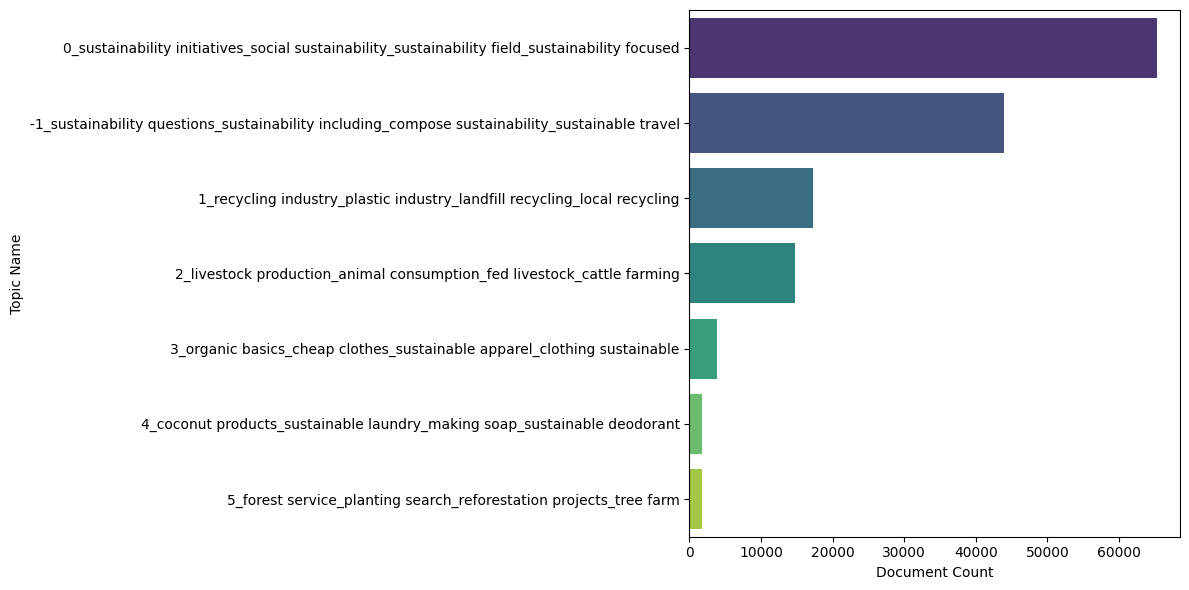

In [ ]:
# Load saved topic info 
PATH = "/content/drive/MyDrive/r_sustainability/topic_info_full.csv"
info = pd.read_csv(PATH)

# Keep all topics
info_sorted = info.sort_values("Count", ascending=False)  # Sort topics by document count (descending)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=info_sorted,
    x="Count",
    y="Name",
    palette="viridis"
)

plt.xlabel("Document Count")
plt.ylabel("Topic Name")
plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'Name' column starts with topic number
topic_0_row = info_sorted[info_sorted['Name'].str.startswith('0_')]

# Or if 'Topic' column exists with topic IDs:
# topic_0_row = info_sorted[info_sorted['Topic'] == 0]

if not topic_0_row.empty:
    exact_count = topic_0_row['Count'].values[0]
    print(f"Exact document count for Topic 0: {exact_count}")
else:
    print("Topic 0 not found in the data.")

Exact document count for Topic 0: 65250


AFFECT SCORING with multiple models:
- Emotions: GoEmotions (transformer) + NRC Emotion Lexicon (lexicon baseline).

- Polarity: RoBERTa sentiment + VADER (baseline).

- Subjectivity: TextBlob (baseline)

In [ ]:
# Loading base table (id, topic, text)
BASE = "/content/drive/MyDrive/r_sustainability"

df_base = pd.read_parquet(f"{BASE}/ALL_with_topics_FULL.parquet",
                          columns=["id","topic","month","kind","text"])
print("Rows for scoring:", len(df_base))
df_base.head()

Rows for scoring: 148578


id  topic    month     kind  \
0  c053uiv      0  2008-08  comment   
1  c05rm75      0  2008-10  comment   
2  c0df81h      0  2009-09  comment   
3  c0dmfqb      0  2009-09  comment   
4  c0elmqx      2  2009-10  comment   

                                                text  
0  this is an excellent introduction to exponenti...  
1                could you put in [video] for these.  
2  'the gift economy and the sustainable communit...  
3  um. &gt; darpa says existing direct and indire...  
4  'insights from soil carbon research: scientist...

# **Emotions: transformer (GoEmotions student) + lexicon baseline (NRC)**


- Loading the GoEmotions student model and tokenizer, and sending the model to GPU if available.  
- Preparing an output folder where I will save emotion-score shards in smaller Parquet files.  
- Setting important parameters such as max text length, batch size, and shard size for safe GPU/CPU processing.  
- Taking all cleaned text and IDs from my dataset and calculating how many shards I need.  
- Creating a function that tokenizes text, runs it through the model in batches, and returns sigmoid probabilities for all emotion labels.  
- Processing the dataset shard-by-shard so the notebook never runs out of memory.  
- Skipping any shard that already exists, which makes the process resumable if it crashes or Colab disconnects.  
- Saving each shard to Parquet with emotion columns like `emo_joy`, `emo_anger`, etc.  


In [ ]:
'''# GoEmotions scoring  GPU-aware, resumable shards, safe truncation

BASE = "/content/drive/MyDrive/r_sustainability"
OUT_DIR = Path(f"{BASE}/_emo_shards")
OUT_DIR.mkdir(parents=True, exist_ok=True)
FINAL_PATH = f"{BASE}/emo_scores_goemotions.parquet"

MODEL_NAME = "joeddav/distilbert-base-uncased-go-emotions-student"  # 27-label student model
MAX_LEN    = 256        # 256 is plenty for comments
SHARD_SIZE = 20_000     # save every 20k rows
device     = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
mdl.eval()
num_labels = mdl.config.num_labels

# Batching: larger if GPU, smaller if CPU
BATCH = 256 if device == "cuda" else 64

# Source texts/ids
texts = df_base["text"].astype(str).tolist()
ids   = df_base["id"].astype(str).tolist()
N     = len(texts)
num_shards = math.ceil(N / SHARD_SIZE)
print(f"Total rows: {N:,}  |  Shards: {num_shards} x {SHARD_SIZE}")

@torch.no_grad()
def score_block(block_texts):
    # Tokenize once per block (fast) and run batched forward
    enc = tok(
        block_texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    enc = {k: v.to(device) for k, v in enc.items()}
    probs_all = []
    for i in range(0, enc["input_ids"].shape[0], BATCH):
        sl = slice(i, i+BATCH)
        logits = mdl(input_ids=enc["input_ids"][sl], attention_mask=enc["attention_mask"][sl]).logits
        # GoEmotions student is multi-label → sigmoid
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        probs_all.append(probs)
    probs_all = np.vstack(probs_all)
    return probs_all  # shape: [len(block_texts), num_labels]

# Get label names from the model config if present; fallback to generic
label_names = getattr(mdl.config, "id2label", None)
if label_names:
    # config.id2label is dict like {0:"admiration", ...}
    label_order = [label_names[i] for i in range(num_labels)]
else:
    # fall back to generic names 0..26
    label_order = [f"label_{i}" for i in range(num_labels)]
colnames = [f"emo_{n}" for n in label_order]

# Process shards (resume if shard parquet already exists)
for s in range(num_shards):
    start = s * SHARD_SIZE
    end   = min((s+1) * SHARD_SIZE, N)
    shard_path = OUT_DIR / f"emo_goemotions_shard_{s:03d}.parquet"
    if shard_path.exists():
        print(f"[skip] shard {s+1}/{num_shards} exists → {shard_path.name}")
        continue

    print(f"[run ] shard {s+1}/{num_shards}  rows {start}..{end-1}")
    block_texts = texts[start:end]
    block_ids   = ids[start:end]
    probs = score_block(block_texts)

    shard_df = pd.DataFrame(probs, columns=colnames)
    shard_df.insert(0, "id", block_ids)
    shard_df.to_parquet(shard_path, index=False)
    del shard_df, probs, block_texts, block_ids
    gc.collect()

print("All shards processed. Concatenating…")

# Concatenate shards → final parquet
parts = sorted(OUT_DIR.glob("emo_goemotions_shard_*.parquet"))
dfs = [pd.read_parquet(p) for p in parts]
emo_df = pd.concat(dfs, ignore_index=True)
emo_df.to_parquet(FINAL_PATH, index=False)
print("Saved GoEmotions →", FINAL_PATH)
print(f"Rows saved: {len(emo_df):,}  |  Columns: {emo_df.shape[1]}")'''


'# GoEmotions scoring  GPU-aware, resumable shards, safe truncation\n\nBASE = "/content/drive/MyDrive/r_sustainability"\nOUT_DIR = Path(f"{BASE}/_emo_shards")\nOUT_DIR.mkdir(parents=True, exist_ok=True)\nFINAL_PATH = f"{BASE}/emo_scores_goemotions.parquet"\n\nMODEL_NAME = "joeddav/distilbert-base-uncased-go-emotions-student"  # 27-label student model\nMAX_LEN    = 256        # 256 is plenty for comments\nSHARD_SIZE = 20_000     # save every 20k rows\ndevice     = "cuda" if torch.cuda.is_available() else "cpu"\nprint("Device:", device)\n\ntok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)\nmdl = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)\nmdl.eval()\nnum_labels = mdl.config.num_labels\n\n# Batching: larger if GPU, smaller if CPU\nBATCH = 256 if device == "cuda" else 64\n\n# Source texts/ids\ntexts = df_base["text"].astype(str).tolist()\nids   = df_base["id"].astype(str).tolist()\nN     = len(texts)\nnum_shards = math.ceil(N / SHARD_SIZE)\nprint

# **NRC emotions (baseline, quick)**


- Loading my dataset that contains topics, months, text, and item types (comment/submission).  
- Creating a function that takes a piece of text and returns its NRC emotion scores (fear, trust, anger, joy, etc.).  
- Normalizing each emotion score by the total so all values fall between 0 and 1.  
- Looping through every text in my dataset, generating NRC emotion scores, and attaching the corresponding ID.  
- Building a DataFrame from all the emotion dictionaries and filling missing values with zeros.  



In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
df_base = pd.read_parquet(f"{BASE}/ALL_with_topics_FULL.parquet",
                          columns=["id","topic","month","kind","text"])

def nrc_emotions_score(text):
    try:
        emo = NRCLex(text or "")
        raw = emo.raw_emotion_scores  # {'fear':2, 'trust':1, ...}
        total = sum(raw.values()) or 1.0
        return {f"nrc_{k}": float(v)/total for k,v in raw.items()}
    except Exception:
        return {}

rows = []
for t, i in zip(df_base["text"].tolist(), df_base["id"].astype(str).tolist()):
    d = nrc_emotions_score(t)
    d["id"] = i
    rows.append(d)

nrc_df = pd.DataFrame(rows).fillna(0.0)
NRC_PATH = f"{BASE}/emo_scores_nrc.parquet"
nrc_df.to_parquet(NRC_PATH, index=False)
print("Saved NRC baseline →", NRC_PATH)

Saved NRC baseline → /content/drive/MyDrive/r_sustainability/emo_scores_nrc.parquet


# VADER polarity
-  Loading my dataset so I can run sentiment scoring on every text entry.  
-  Creating a VADER sentiment analyzer object.  
-  Computing the *compound polarity score* for each text, which gives a value between -1 (very negative) and +1 (very positive).  
-  Building a new DataFrame that contains the item ID and its corresponding VADER sentiment score.  


In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
an = SentimentIntensityAnalyzer()
pol = [an.polarity_scores(s or "")["compound"] for s in df_base["text"].tolist()]
vader_df = pd.DataFrame({"id": df_base["id"].astype(str).tolist(), "pol_vader": pol})

VADER_PATH = f"{BASE}/pol_scores_vader.parquet"
vader_df.to_parquet(VADER_PATH, index=False)
print("Saved VADER →", VADER_PATH)

Saved VADER → /content/drive/MyDrive/r_sustainability/pol_scores_vader.parquet


# **Subjectivity (TextBlob; quick)**

- Taking every text entry from my dataset and using TextBlob to compute its subjectivity (from 0 = objective to 1 = subjective).  
- Creating a new DataFrame that stores each item’s ID along with its calculated subjectivity score.  


In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
subj = [float(TextBlob(s or "").sentiment.subjectivity) for s in df_base["text"].tolist()]
subj_df = pd.DataFrame({"id": df_base["id"].astype(str).tolist(), "subjectivity": subj})

SUBJ_PATH = f"{BASE}/subj_scores_textblob.parquet"
subj_df.to_parquet(SUBJ_PATH, index=False)
print("Saved subjectivity →", SUBJ_PATH)

Saved subjectivity → /content/drive/MyDrive/r_sustainability/subj_scores_textblob.parquet


## **Merge all scores → Aggregates → CSVs**

-  Loading my main topic-labelled dataset along with all emotion and sentiment score files (GoEmotions, NRC, VADER, and TextBlob).  
-  Merging all these datasets together using the `id` column so each text has its topic, emotions, polarity, and subjectivity in one place.  
-  Creating topic-level emotion summaries by averaging GoEmotions scores across each topic.  
-  Also calculating average NRC lexicon emotion scores for each topic.  
-  Computing sentiment measures (VADER polarity + subjectivity) per topic using mean, median, and count.  
-  Calculating monthly VADER polarity trends for each topic to see how sentiment changes over time.  



In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
base  = pd.read_parquet(f"{BASE}/ALL_with_topics_FULL.parquet",
                        columns=["id","topic","month","kind","text"])

emo_t = pd.read_parquet(f"{BASE}/emo_scores_goemotions.parquet")   # transformer emotions
emo_l = pd.read_parquet(f"{BASE}/emo_scores_nrc.parquet")          # lexicon emotions
vad   = pd.read_parquet(f"{BASE}/pol_scores_vader.parquet")
subj  = pd.read_parquet(f"{BASE}/subj_scores_textblob.parquet")

dfm = (base
       .merge(emo_t, on="id", how="left")
       .merge(emo_l, on="id", how="left")
       .merge(vad,   on="id", how="left")
       .merge(subj,  on="id", how="left"))

print("Merged rows:", len(dfm))

# Topic-level aggregates
emo_t_cols   = [c for c in dfm.columns if c.startswith("emo_") and not c.startswith("emo_nrc_")]
emo_nrc_cols = [c for c in dfm.columns if c.startswith("nrc_")]

topic_emo_t   = dfm.groupby("topic")[emo_t_cols].mean()
topic_emo_nrc = dfm.groupby("topic")[emo_nrc_cols].mean()
topic_affect  = dfm.groupby("topic")[["pol_vader","subjectivity"]].agg(["mean","median","count"])

# Monthly polarity trend (VADER)
topic_month_pol = dfm.groupby(["topic","month"])["pol_vader"].mean().reset_index()

topic_emo_t.to_csv(f"{BASE}/out_topic_emotions_goemotions.csv")
topic_emo_nrc.to_csv(f"{BASE}/out_topic_emotions_nrc.csv")
topic_affect.to_csv(f"{BASE}/out_topic_affect_vader_subj.csv")
topic_month_pol.to_csv(f"{BASE}/out_topic_month_vader.csv", index=False)

print("Saved aggregates CSVs to Drive.")

Merged rows: 148728
Saved aggregates CSVs to Drive.


# Visualizations


-  Loading the CSV file that contains topic-level polarity and subjectivity statistics.  
-  Fixing the multi-index column names so the dataset becomes easy to work with (e.g., turning `('pol_vader','mean')` into `pol_vader_mean`).  
-  Selecting the top 15 largest topics based on how many documents they have (`pol_vader_count`).  
-  Plotting these topics on a scatter plot, using VADER mean polarity on the x-axis and TextBlob mean subjectivity on the y-axis.  
-  Adding topic IDs as text labels next to each point so I can see which topic is which.  
-  Labeling the axes and adding a title to show what the chart represents.  
-  Displaying the final scatter plot to visually compare emotional tone across the biggest topics.


## Polarity vs subjectivity

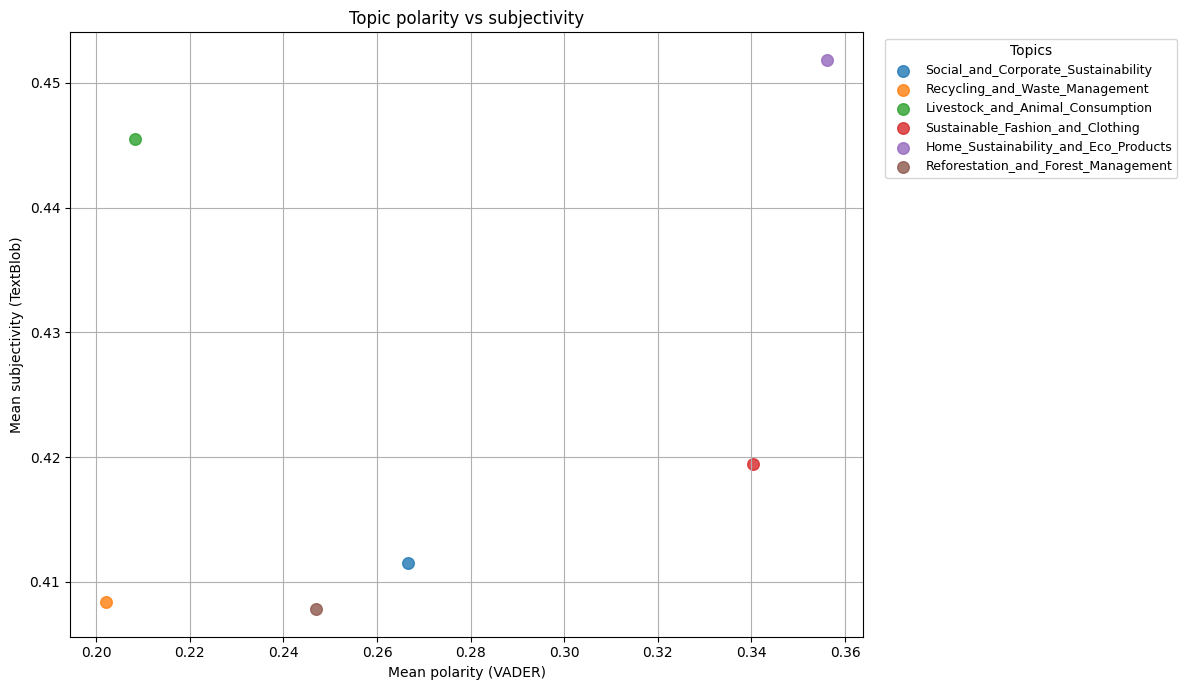

In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
AFFECT_CSV = f"{BASE}/out_topic_affect_vader_subj.csv"
INFO_CSV   = f"{BASE}/topic_info_full.csv"


# Load topic names (exclude -1)
topic_names = {
    -1: "Sustainability_Issues (Outliers)",
    0: "Social_and_Corporate_Sustainability",
    1: "Recycling_and_Waste_Management",
    2: "Livestock_and_Animal_Consumption",
    3: "Sustainable_Fashion_and_Clothing",
    4: "Home_Sustainability_and_Eco_Products",
    5: "Reforestation_and_Forest_Management"
}

aff = (
    pd.read_csv(AFFECT_CSV, header=[0, 1], index_col=0)
      .reset_index()
      .rename(columns={"index": "topic"})
)

# Flatten multi-index column names
aff.columns = ["topic"] + [f"{a}_{b}" for (a, b) in aff.columns[1:]]

# Remove topic -1 from affect dataframe
aff = aff[aff["topic"] != -1]                  # <-- remove noise here too

top = aff.sort_values("pol_vader_count", ascending=False).head(15)

# Keep only topics also present in info (safety)
top = top[top["topic"].isin(topic_names.keys())]
plt.figure(figsize=(12, 7))

# Plot each topic
for tid in top["topic"]:
    sub = top[top["topic"] == tid]
    label = topic_names.get(tid, f"Topic {tid}")
    plt.scatter(sub["pol_vader_mean"], sub["subjectivity_mean"], s=70, label=label, alpha=0.8)

# Add labels and title
plt.xlabel("Mean polarity (VADER)")
plt.ylabel("Mean subjectivity (TextBlob)")
plt.title("Topic polarity vs subjectivity")

# Enable the grid for better visual
plt.grid(True)


legend = plt.legend(
    title="Topics",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=9,
)

# Adjust layout to prevent clipping of the legend
plt.tight_layout()
plt.show()

In [ ]:
#  Select the columns for mean polarity and subjectivity
columns_of_interest = ['pol_vader_mean', 'subjectivity_mean']

# Create a dictionary to store topic names with their numerical results
topic_results = {}

for tid in top["topic"]:
    sub = top[top["topic"] == tid]
    topic_name = topic_names.get(tid, f"Topic {tid}")
    mean_polarity = sub["pol_vader_mean"].values[0]
    mean_subjectivity = sub["subjectivity_mean"].values[0]

    topic_results[topic_name] = {
        'Mean Polarity (VADER)': mean_polarity,
        'Mean Subjectivity (TextBlob)': mean_subjectivity
    }

# Print the results in a readable format
print("Numerical Results for Each Topic:\n")
for topic, results in topic_results.items():
    print(f"{topic}:")
    print(f"  Mean Polarity (VADER): {results['Mean Polarity (VADER)']:.4f}")
    print(f"  Mean Subjectivity (TextBlob): {results['Mean Subjectivity (TextBlob)']:.4f}")
    print("-" * 50)  # Separator between topics

Numerical Results for Each Topic:

Social_and_Corporate_Sustainability:
  Mean Polarity (VADER): 0.2666
  Mean Subjectivity (TextBlob): 0.4115
--------------------------------------------------
Recycling_and_Waste_Management:
  Mean Polarity (VADER): 0.2021
  Mean Subjectivity (TextBlob): 0.4084
--------------------------------------------------
Livestock_and_Animal_Consumption:
  Mean Polarity (VADER): 0.2082
  Mean Subjectivity (TextBlob): 0.4455
--------------------------------------------------
Sustainable_Fashion_and_Clothing:
  Mean Polarity (VADER): 0.3404
  Mean Subjectivity (TextBlob): 0.4194
--------------------------------------------------
Home_Sustainability_and_Eco_Products:
  Mean Polarity (VADER): 0.3562
  Mean Subjectivity (TextBlob): 0.4519
--------------------------------------------------
Reforestation_and_Forest_Management:
  Mean Polarity (VADER): 0.2470
  Mean Subjectivity (TextBlob): 0.4078
--------------------------------------------------


## Emotion heatmap (GoEmotions means, big topics)

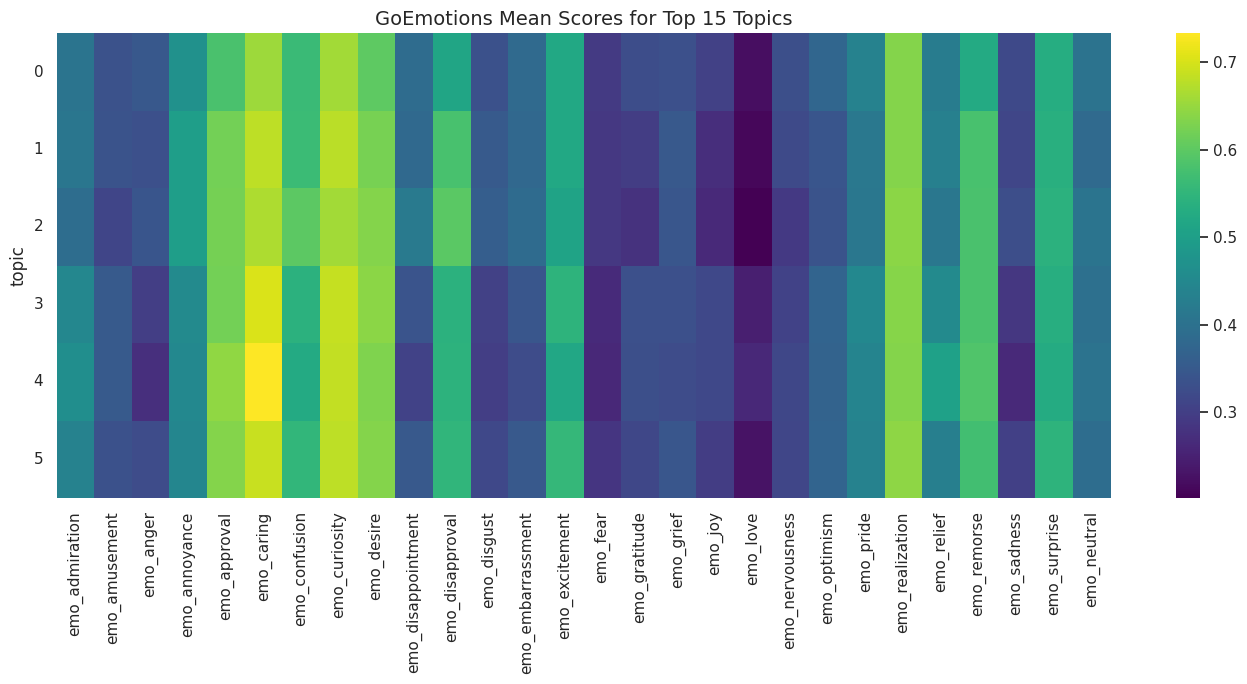

In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
INFO_CSV = f"{BASE}/topic_info_full.csv"
EMO_CSV  = f"{BASE}/out_topic_emotions_goemotions.csv"

# Load info
info = pd.read_csv(INFO_CSV)
big_ids = (
    info[info["Topic"] != -1]
        .sort_values("Count", ascending=False)
        .head(15)["Topic"]
        .astype(int)
        .tolist()
)

# Load GoEmotions per topic
emo_t = pd.read_csv(EMO_CSV, index_col=0)
emo_t.index = emo_t.index.astype(int)

# Select topics that exist
sel_ids = [tid for tid in big_ids if tid in emo_t.index]
emo_t_sel = emo_t.loc[sel_ids].fillna(0.0)

# Plot heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(
    emo_t_sel,
    cmap="viridis",
    annot=False,
    cbar=True
)

plt.yticks(rotation=0)  # keep topic IDs readable
plt.xticks(rotation=90)
plt.title("GoEmotions Mean Scores for Top 15 Topics", fontsize=14)
plt.tight_layout()
plt.show()

## Monthly polarity trends

**Monthly polarity trend (pick the biggest topic)**

- The cell below loads topic information and monthly VADER polarity scores from CSV files stored in Google Drive.

- It identifies the largest non-outlier topic by selecting the topic with the highest document count (excluding topic –1).

- It then filters the monthly polarity dataset so that only rows belonging to this largest topic remain.

- The code sorts these rows by month to ensure the trend is plotted in chronological order.

- It creates a line plot showing how the mean VADER polarity changes month-by-month for this top topic.

- The x-axis labels are rotated for better readability, and the plot is given a descriptive title.

- Finally, the plot is displayed to show the monthly sentiment trend for the most prominent topic.

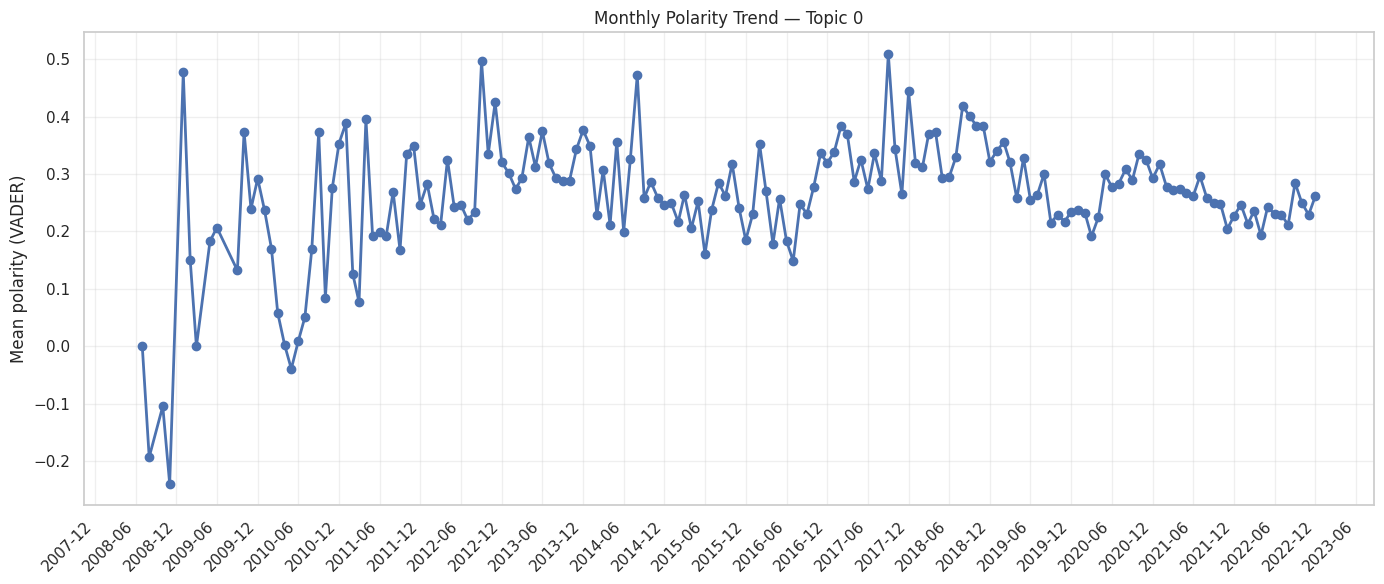

In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
MONTH_CSV = f"{BASE}/out_topic_month_vader.csv"
INFO_CSV  = f"{BASE}/topic_info_full.csv"

# Load top topic
info = pd.read_csv(INFO_CSV)
top_topic = int(info[info["Topic"] != -1].sort_values("Count", ascending=False).iloc[0]["Topic"])

# Load monthly polarity
tm = pd.read_csv(MONTH_CSV)
tm = tm[tm["topic"] == top_topic].copy()

# Convert month → datetime
tm["month"] = pd.to_datetime(tm["month"])
tm = tm.sort_values("month")

# Plot
plt.figure(figsize=(14,6))
plt.plot(tm["month"], tm["pol_vader"], marker="o", linewidth=2)

# Format x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))   # tick every 6 months
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)

plt.ylabel("Mean polarity (VADER)")
plt.title(f"Monthly Polarity Trend — Topic {top_topic}")
plt.tight_layout()
plt.show()

## Yearly polairty Trends

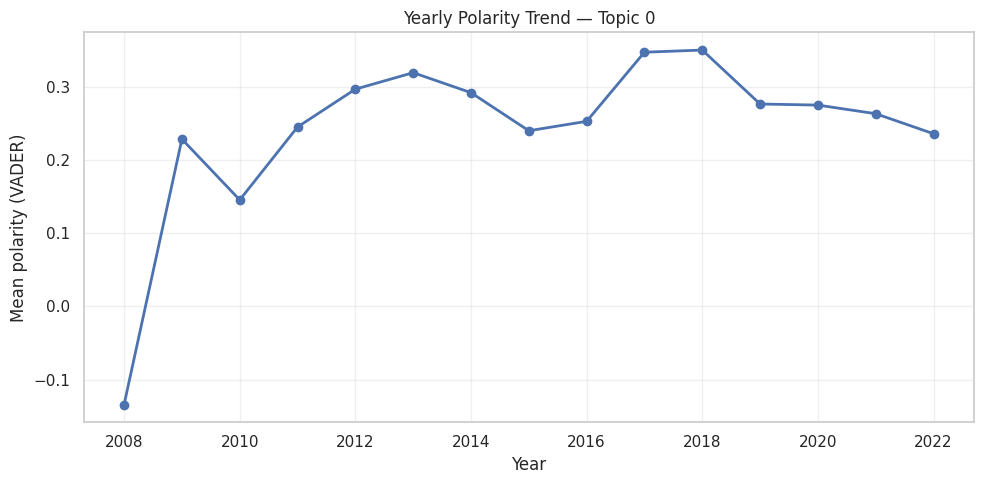

In [ ]:
# Compute average polarity per year
tm["year"] = tm["month"].dt.year
ty = tm.groupby("year")["pol_vader"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(ty["year"], ty["pol_vader"], marker="o", linewidth=2)

plt.grid(alpha=0.3)
plt.xlabel("Year")
plt.ylabel("Mean polarity (VADER)")
plt.title(f"Yearly Polarity Trend — Topic {top_topic}")
plt.tight_layout()
plt.show()

Next:

- The code in the cell below merges the emotion scores with the topic assignments so each text entry includes both its topic label and its emotion values

- The previously trained BERTopic model is loaded to allow retrieval of representative documents and topic keywords.

- The code identifies the top 10 largest non-outlier topics by sorting topics based on the number of documents assigned to them (excluding topic –1).

- For each of these top topics, the code prints a detailed topic profile using a custom function.

This function displays:

- The topic number and its top descriptive words (label terms).

- A set of representative text examples that best illustrate the topic content.

- The top emotional dimensions (based on GoEmotions mean values) associated with that topic.

- The code loops through all top 10 topics and prints this profile for each one, helping the user understand the semantic meaning and emotional tone of the most prominent topics.

## Topic profiles

In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"
ASSIGN_PATH = f"{BASE}/ALL_with_topics_FULL.parquet"
EMO_PATH = f"{BASE}/emo_scores_goemotions.parquet"
MODEL_PATH = f"{BASE}/bertopic_full_model"

# Load topic assignments + emotions
df_topics = pd.read_parquet(ASSIGN_PATH)
emo_df = pd.read_parquet(EMO_PATH)

# Merge emotions onto topics
df_merged = df_topics.merge(emo_df, on="id", how="left")

# Load model to get representative docs
topic_model = BERTopic.load(MODEL_PATH)

# Get top 10 largest non-outlier topics
info = topic_model.get_topic_info()
top10 = info[info["Topic"] != -1].sort_values("Count", ascending=False).head(10)
top10_topics = top10["Topic"].tolist()

print("Top 10 Topics:", top10_topics)

def show_topic_profile(topic_id, n_examples=5):
    print("="*90)
    print(f"TOPIC {topic_id}:")
    print("Label Terms →", topic_model.get_topic(topic_id))

    # Representative comments
    print("\nRepresentative Comments:")
    reps = topic_model.get_representative_docs(topic_id)[:n_examples]
    for i, txt in enumerate(reps, 1):
        print(f"[{i}] {txt[:350]}...\n")

    # Mean emotion scores
    emo_cols = [c for c in df_merged.columns if c.startswith("emo_")]
    emo_means = df_merged[df_merged["topic"] == topic_id][emo_cols].mean().sort_values(ascending=False)
    print("\nTop Emotions:")
    print(emo_means.head(8))

# Show results for each of the top 10 topics
for t in top10_topics:
    show_topic_profile(t)

Top 10 Topics: [0, 1, 2, 3, 4, 5]
TOPIC 0:
Label Terms → [('sustainability initiatives', np.float32(0.48114336)), ('social sustainability', np.float32(0.48097274)), ('sustainability field', np.float32(0.44838363)), ('sustainability focused', np.float32(0.44493517)), ('business sustainability', np.float32(0.42963699)), ('sustainability business', np.float32(0.41527426)), ('energy sustainability', np.float32(0.40928972)), ('environmental movement', np.float32(0.40810066)), ('corporate sustainability', np.float32(0.40185207)), ('sustainability management', np.float32(0.39973187))]

Representative Comments:
[1] cambridge's 'passive house' is built with focus on affordable housing, climate change...

[2] as a layperson, here is my guess of what the answer is: a. current widespread scalable heat pump technology actually works pretty well in low temperatures. b. the real impact of heat pumps, however, comes from their ability to displace gas use on moderately cold days, and to reduce gas use 

In [ ]:
BASE = "/content/drive/MyDrive/r_sustainability"

# Load topic assignments
df_topics = pd.read_parquet(f"{BASE}/ALL_with_topics_FULL.parquet")

# Load emotion scores
emo_df = pd.read_parquet(f"{BASE}/emo_scores_goemotions.parquet")

# Merge (keeps only matched rows)
dfm = df_topics.merge(emo_df, on="id", how="inner")

print("Merged shape:", dfm.shape)

# Keep only non-outlier topics (optional but improves clarity)
dfm = dfm[dfm["topic"] != -1].copy()

# Identify emotion columns
emo_cols = [c for c in dfm.columns if c.startswith("emo_")]
print("Emotion columns:", emo_cols[:10], "... total:", len(emo_cols))

Merged shape: (148588, 34)
Emotion columns: ['emo_admiration', 'emo_amusement', 'emo_anger', 'emo_annoyance', 'emo_approval', 'emo_caring', 'emo_confusion', 'emo_curiosity', 'emo_desire', 'emo_disappointment'] ... total: 28


## **Summary Table of Mean Emotion per Topic**

In [ ]:
topic_emo = dfm.groupby("topic")[emo_cols].mean()
topic_emo.round(3)

emo_admiration  emo_amusement  emo_anger  emo_annoyance  emo_approval  \
topic                                                                          
0               0.405          0.335      0.346          0.468         0.580   
1               0.411          0.337      0.331          0.497         0.620   
2               0.389          0.310      0.342          0.497         0.623   
3               0.447          0.349      0.297          0.454         0.621   
4               0.463          0.351      0.273          0.449         0.645   
5               0.438          0.332      0.323          0.446         0.634   

       emo_caring  emo_confusion  emo_curiosity  emo_desire  \
topic                                                         
0           0.656          0.562          0.659       0.600   
1           0.680          0.565          0.677       0.625   
2           0.668          0.600          0.659       0.634   
3           0.703          0.542          0.686       0.641   
4           0.733          0.524          0.685       0.630   
5           0.689          0.552          0.680       0.635   

       emo_disappointment  ...  emo_love  emo_nervousness  emo_optimism  \
topic                      ...                                            
0                   0.388  ...     0.221            0.329         0.376   
1                   0.382  ...     0.211            0.321         0.343   
2                   0.420  ...     0.201            0.290         0.337   
3                   0.340  ...     0.247            0.306         0.372   
4                   0.307  ...     0.260            0.314         0.368   
5                   0.347  ...     0.228            0.312         0.371   

       emo_pride  emo_realization  emo_relief  emo_remorse  emo_sadness  \
topic                                                                     
0          0.435            0.634       0.423        0.524        0.319   
1          0.414            0.634       0.431        0.579        0.312   
2          0.411            0.641       0.411        0.580        0.328   
3          0.449            0.637       0.455        0.580        0.285   
4          0.440            0.635       0.503        0.587        0.262   
5          0.436            0.643       0.428        0.572        0.303   

       emo_surprise  emo_neutral  
topic                             
0             0.531        0.403  
1             0.537        0.384  
2             0.541        0.407  
3             0.535        0.396  
4             0.526        0.405  
5             0.545        0.389  

[6 rows x 28 columns]

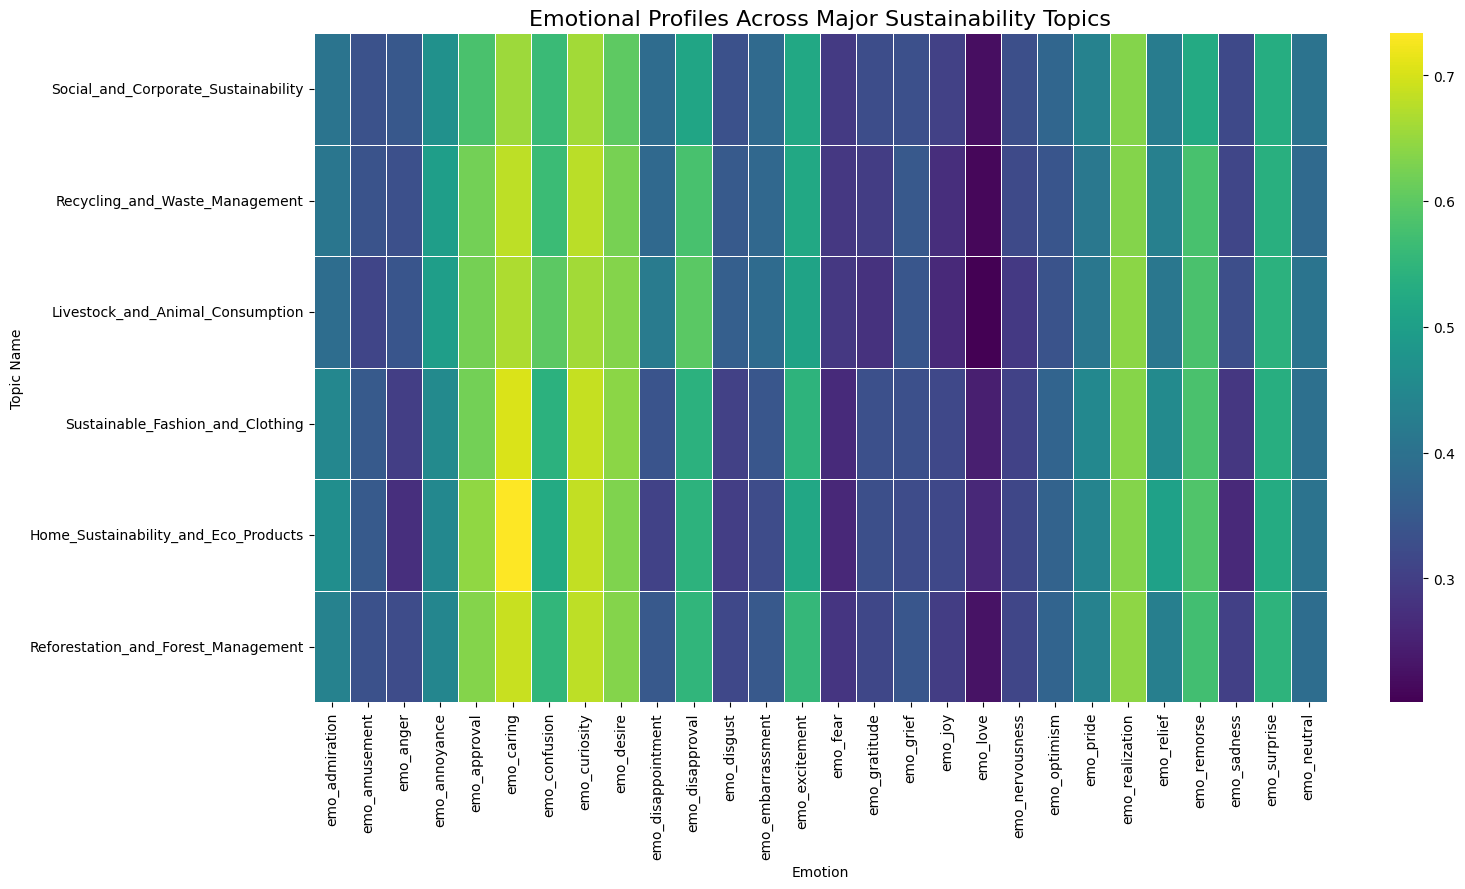

In [ ]:
# Base directory
BASE = "/content/drive/MyDrive/r_sustainability"

# Load files
info = pd.read_csv(f"{BASE}/topic_info_full.csv")
df_topics = pd.read_parquet(f"{BASE}/ALL_with_topics_FULL.parquet")
emo_df = pd.read_parquet(f"{BASE}/emo_scores_goemotions.parquet")

# Merge dataframes
dfm = df_topics.merge(emo_df, on="id", how="inner")
dfm = dfm[dfm["topic"] != -1].copy()

# Emotion columns
emo_cols = [c for c in dfm.columns if c.startswith("emo_")]

# Top 6 topics (0–5) based on output
top_topics = [0, 1, 2, 3, 4, 5]

# Topic names map (updated as per your request)
topic_names = {
    -1: "Sustainability_Issues (Outliers)",
    0: "Social_and_Corporate_Sustainability",
    1: "Recycling_and_Waste_Management",
    2: "Livestock_and_Animal_Consumption",
    3: "Sustainable_Fashion_and_Clothing",
    4: "Home_Sustainability_and_Eco_Products",
    5: "Reforestation_and_Forest_Management"
}

# Compute mean emotion profile for the top topics
topic_emotions = (
    dfm.groupby("topic")[emo_cols]
       .mean()
       .loc[top_topics]
)

# Replace Topic IDs with Topic Names
topic_emotions.index = topic_emotions.index.map(topic_names)

# Plotting the heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(topic_emotions, cmap="viridis", linewidths=0.4)
plt.title("Emotional Profiles Across Major Sustainability Topics", fontsize=16)
plt.xlabel("Emotion")
plt.ylabel("Topic Name")
plt.tight_layout()
plt.show()

## **Bar Chart: Top Emotion for Each Topic**

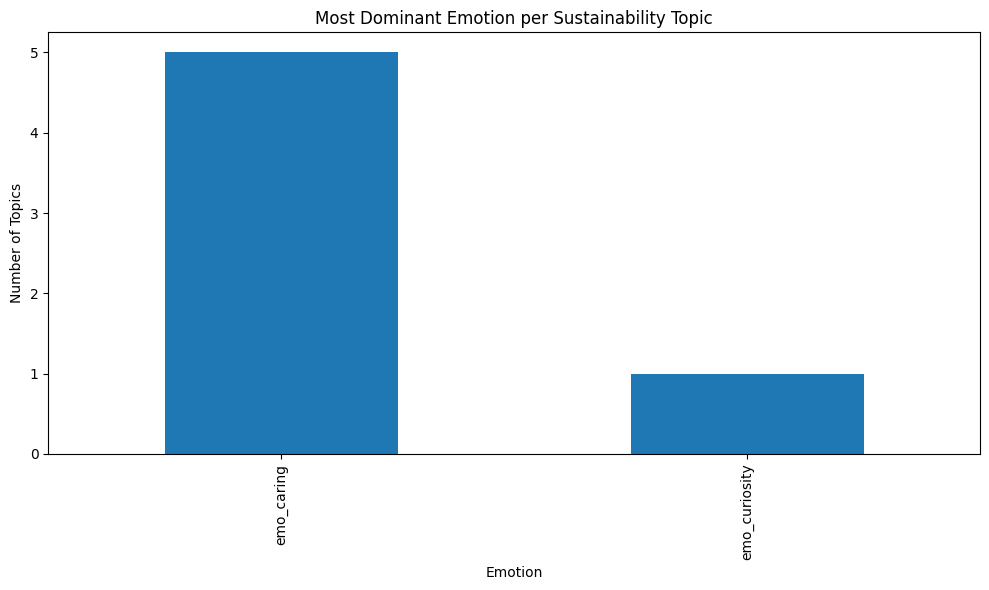

In [ ]:
top_emo = topic_emo.idxmax(axis=1)

plt.figure(figsize=(10,6))
top_emo.value_counts().plot(kind='bar')
plt.title("Most Dominant Emotion per Sustainability Topic")
plt.xlabel("Emotion")
plt.ylabel("Number of Topics")
plt.tight_layout()
plt.show()

## **Emotion Change Over Time**

In [ ]:
dfm.columns.tolist()

['id',
 'created_dt',
 'month',
 'kind',
 'text',
 'topic',
 'emo_admiration',
 'emo_amusement',
 'emo_anger',
 'emo_annoyance',
 'emo_approval',
 'emo_caring',
 'emo_confusion',
 'emo_curiosity',
 'emo_desire',
 'emo_disappointment',
 'emo_disapproval',
 'emo_disgust',
 'emo_embarrassment',
 'emo_excitement',
 'emo_fear',
 'emo_gratitude',
 'emo_grief',
 'emo_joy',
 'emo_love',
 'emo_nervousness',
 'emo_optimism',
 'emo_pride',
 'emo_realization',
 'emo_relief',
 'emo_remorse',
 'emo_sadness',
 'emo_surprise',
 'emo_neutral']

In [ ]:
dfm["created_dt"] = pd.to_datetime(dfm["created_dt"], errors="coerce")

In [ ]:
dfm["year_month"] = dfm["created_dt"].dt.to_period("M").astype(str)

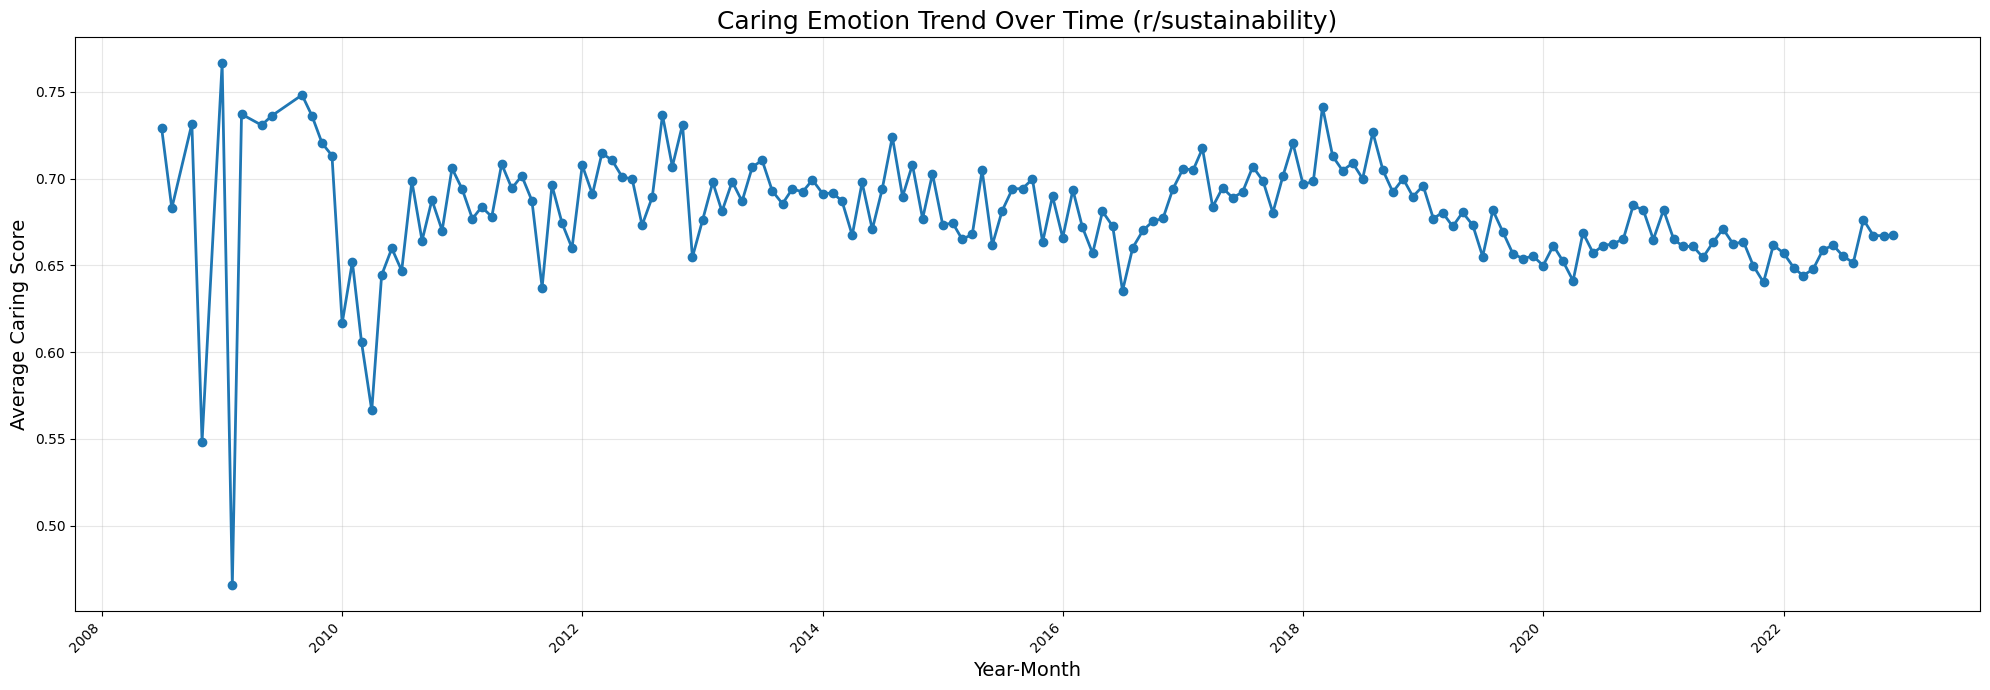

In [ ]:
# Ensure year_month is datetime for correct sorting
dfm["year_month"] = pd.to_datetime(dfm["year_month"])

# Compute monthly trend
trend = (
    dfm.groupby("year_month")["emo_caring"]
       .mean()
       .reset_index()
       .sort_values("year_month")
)

plt.figure(figsize=(20,7))
plt.plot(trend["year_month"], trend["emo_caring"], marker='o', linewidth=2)

plt.title("Caring Emotion Trend Over Time (r/sustainability)", fontsize=18)
plt.xlabel("Year-Month", fontsize=14)
plt.ylabel("Average Caring Score", fontsize=14)

plt.grid(alpha=0.3)

# Improve x-axis readability
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
def plot_topic_emotions(topic_names, top_n=8):
    subset = dfm[dfm["topic"] == topic_names]
    emo_cols = [c for c in dfm.columns if c.startswith("emo_")]
    mean_scores = subset[emo_cols].mean().sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10,6))
    sns.barplot(x=mean_scores.values, y=mean_scores.index, palette="viridis")
    plt.title(f"Top {top_n} Emotions in Topic {topic_names}")
    plt.xlabel("Average Score")
    plt.ylabel("Emotion")
    plt.show()

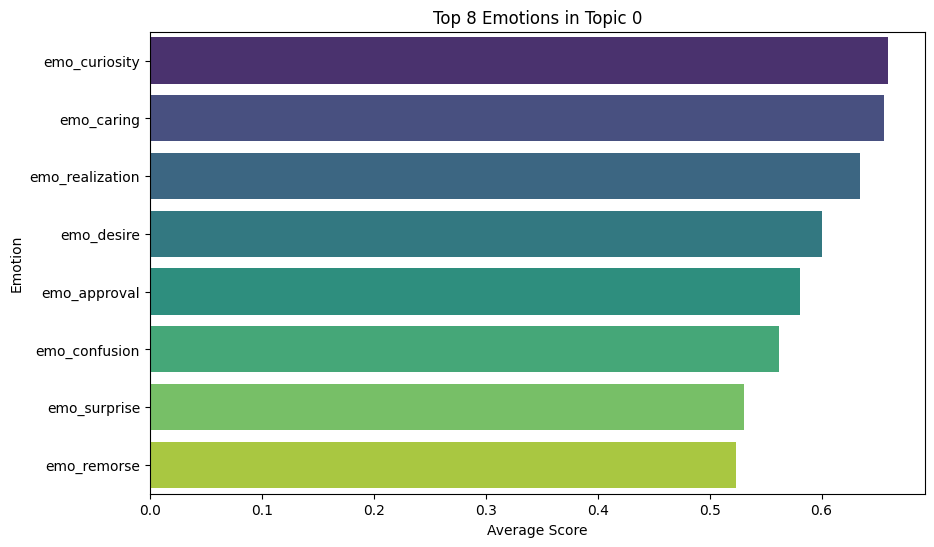

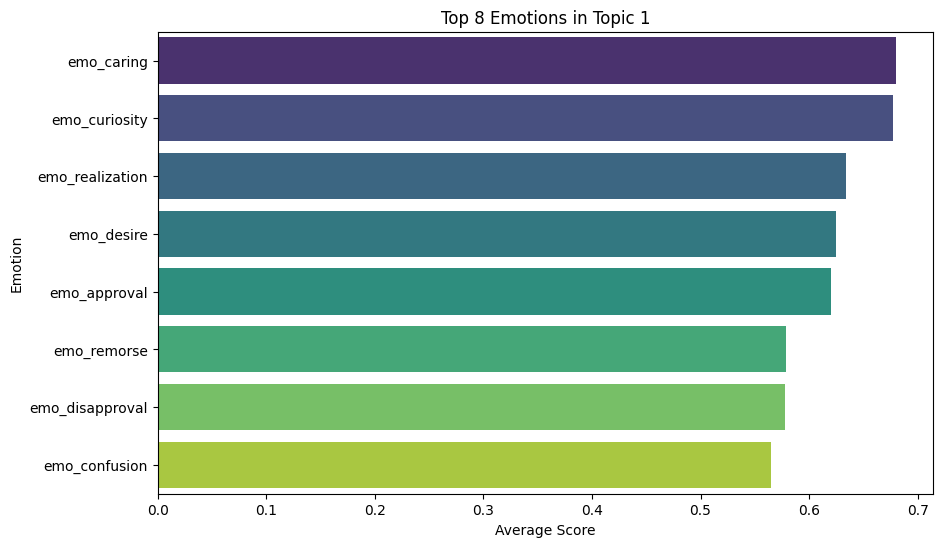

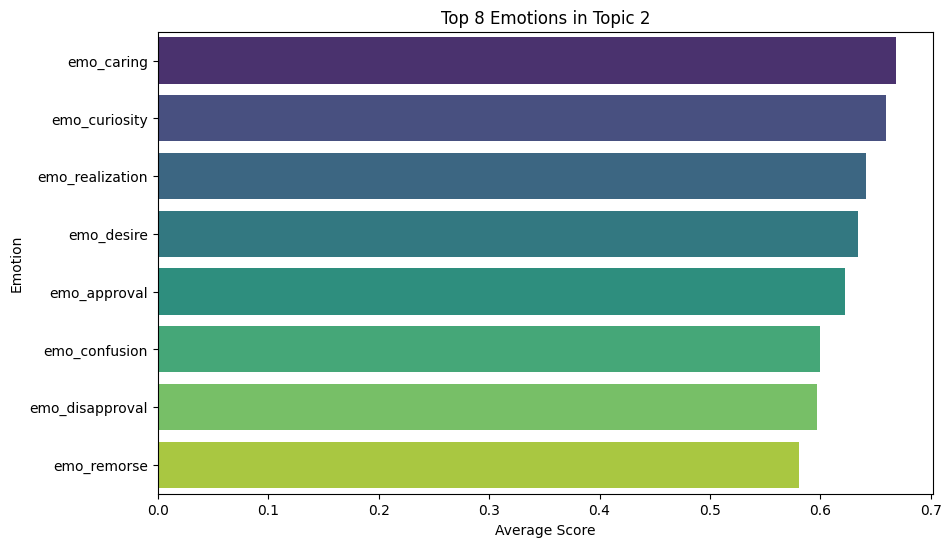

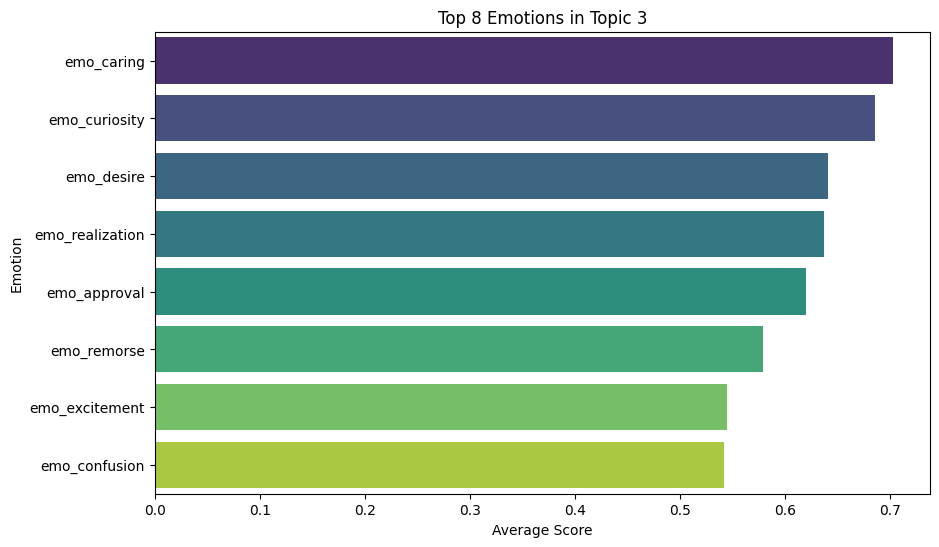

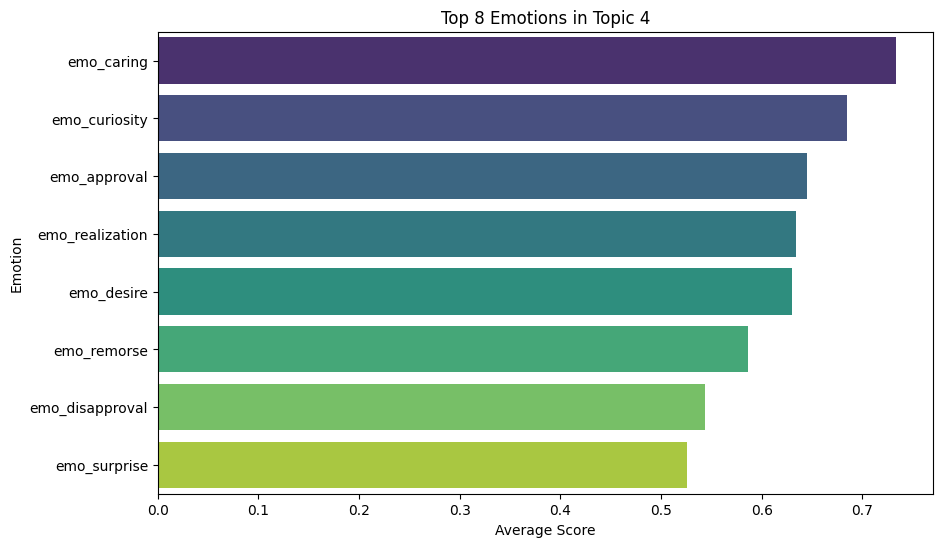

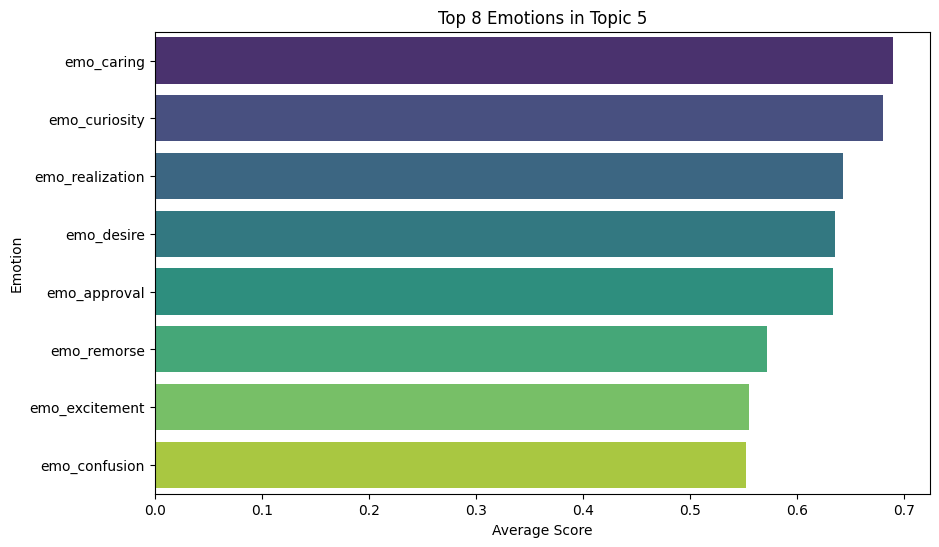

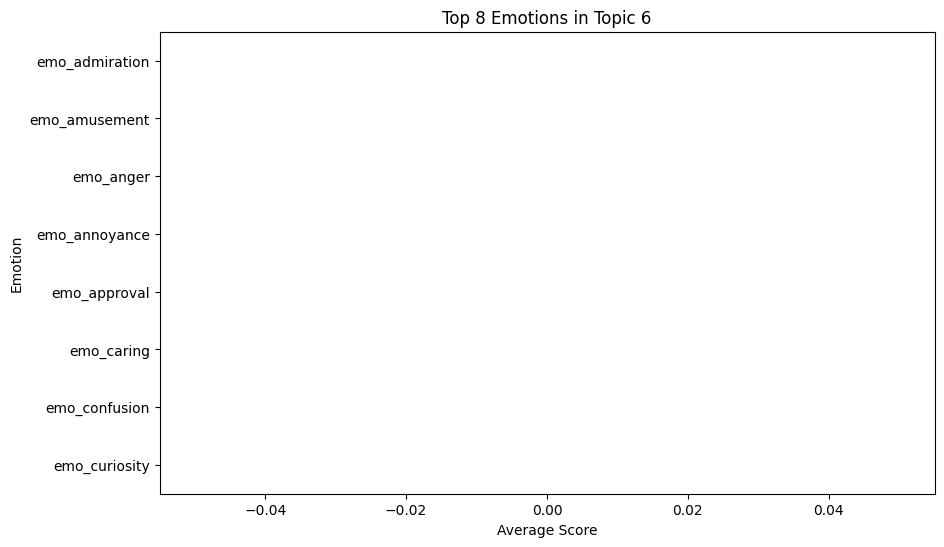

In [ ]:
plot_topic_emotions(0)
plot_topic_emotions(1)
plot_topic_emotions(2)
plot_topic_emotions(3)
plot_topic_emotions(4)
plot_topic_emotions(5)
plot_topic_emotions(6)

# Topic Naming and Mapping

In [ ]:
# Load topic info
topic_info = pd.read_csv("/content/drive/MyDrive/r_sustainability/topic_info_full.csv")

# Define readable topic names
topic_names = {
    -1: "Sustainability_Issues (Outliers)",
    0: "Social_and_Corporate_Sustainability",
    1: "Recycling_and_Waste_Management",
    2: "Livestock_and_Animal_Consumption",
    3: "Sustainable_Fashion_and_Clothing",
    4: "Home_Sustainability_and_Eco_Products",
    5: "Reforestation_and_Forest_Management"
}

topic_info["Topic_Name"] = topic_info["Topic"].map(topic_names)

# Create continuous numbering 1,2,3… instead of -1,0,1…
unique_topics = sorted(topic_info["Topic"].unique())
topic_id_map = {old: new+1 for new, old in enumerate(unique_topics)}
topic_info["Topic_Num"] = topic_info["Topic"].map(topic_id_map)

# Rename Topic → topic so it matches dfm
topic_info = topic_info.rename(columns={"Topic": "topic"})

# Save cleaned topic info
topic_info.to_csv("/content/drive/MyDrive/r_sustainability/topic_info_clean.csv", index=False)
print(" Saved cleaned topic info → topic_info_clean.csv")

# Merge into the main dataframe dfm
print("Columns in dfm before merge:", dfm.columns.tolist())
dfm = dfm.merge(topic_info[["topic", "Topic_Name", "Topic_Num"]], on="topic", how="left")
print("\n Merged. Sample rows:")
print(dfm[["topic", "Topic_Num", "Topic_Name"]].head())

 Saved cleaned topic info → topic_info_clean.csv
Columns in dfm before merge: ['id', 'created_dt', 'month', 'kind', 'text', 'topic', 'emo_admiration', 'emo_amusement', 'emo_anger', 'emo_annoyance', 'emo_approval', 'emo_caring', 'emo_confusion', 'emo_curiosity', 'emo_desire', 'emo_disappointment', 'emo_disapproval', 'emo_disgust', 'emo_embarrassment', 'emo_excitement', 'emo_fear', 'emo_gratitude', 'emo_grief', 'emo_joy', 'emo_love', 'emo_nervousness', 'emo_optimism', 'emo_pride', 'emo_realization', 'emo_relief', 'emo_remorse', 'emo_sadness', 'emo_surprise', 'emo_neutral', 'year_month']

 Merged. Sample rows:
   topic  Topic_Num                           Topic_Name
0      0          2  Social_and_Corporate_Sustainability
1      0          2  Social_and_Corporate_Sustainability
2      0          2  Social_and_Corporate_Sustainability
3      0          2  Social_and_Corporate_Sustainability
4      2          4     Livestock_and_Animal_Consumption


## Emotion Change over Time by Topic

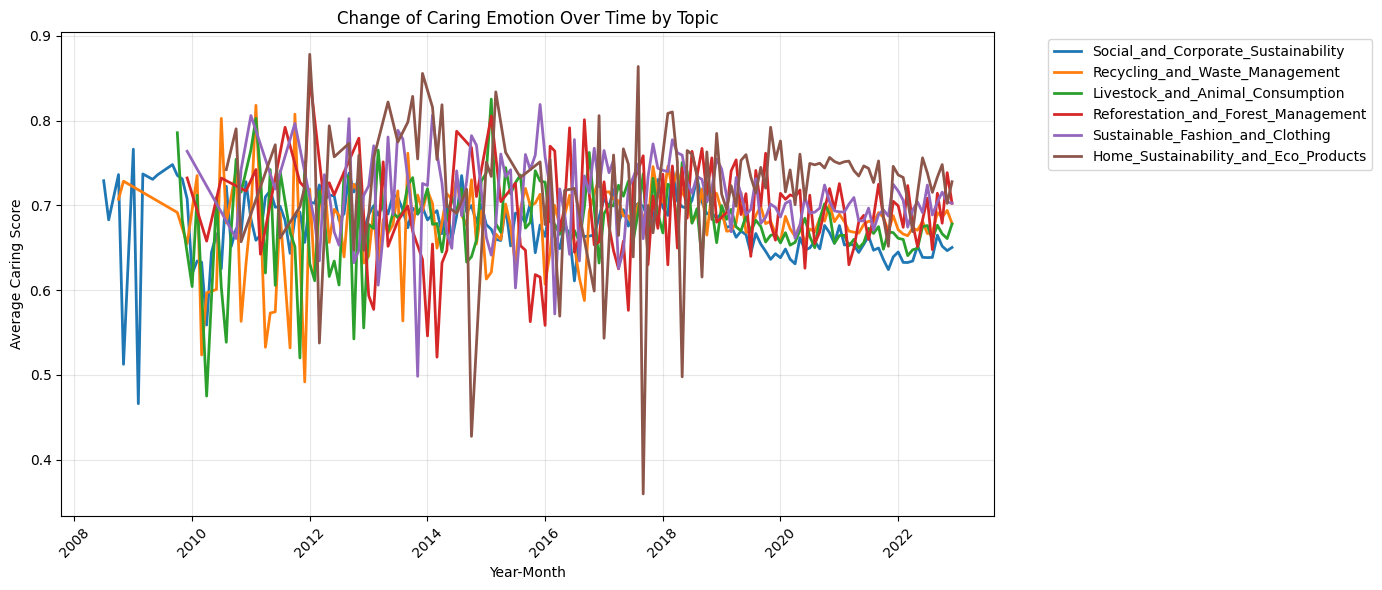

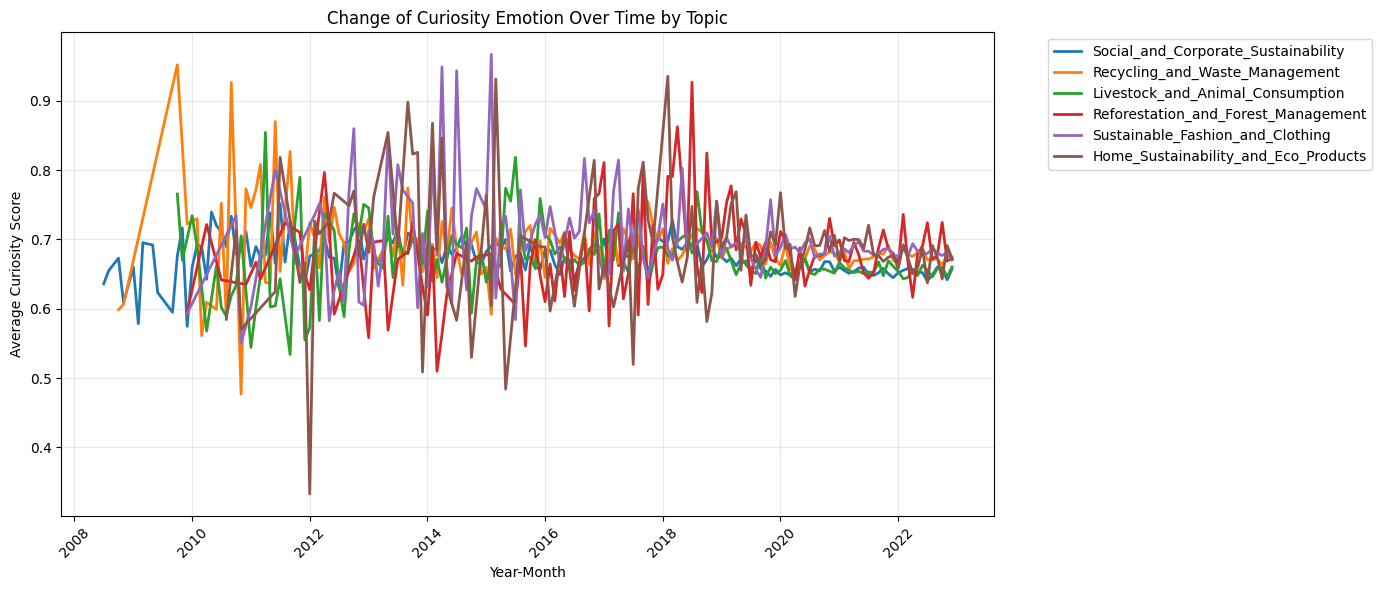

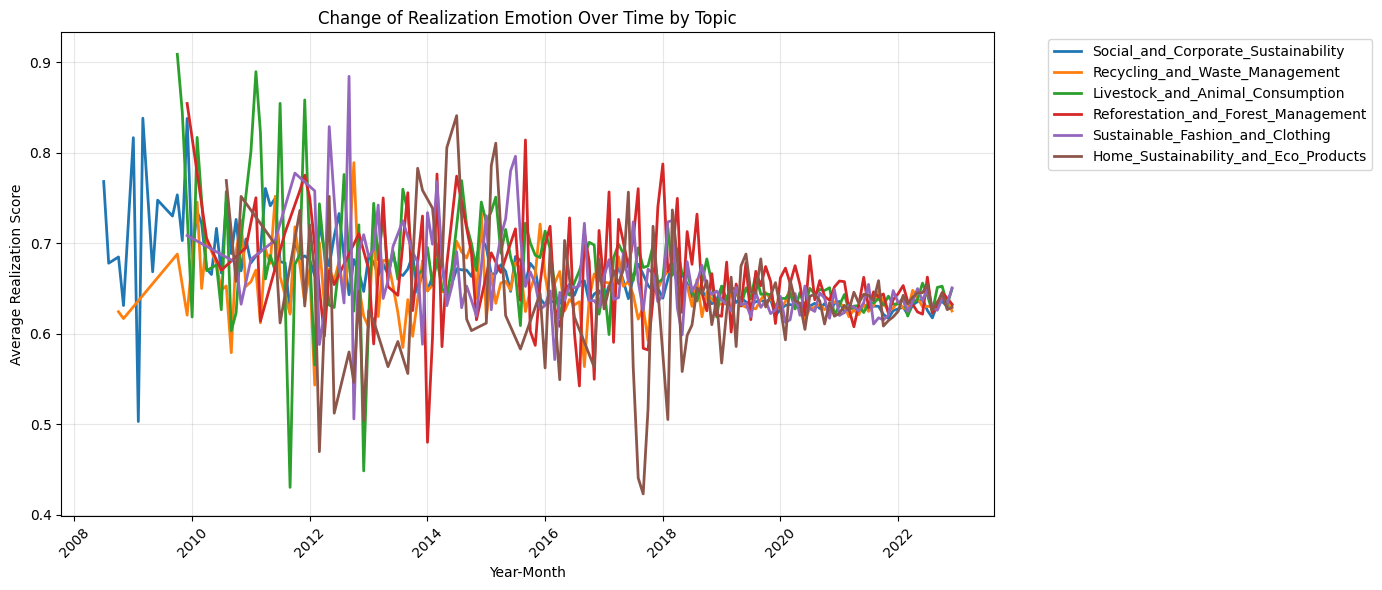

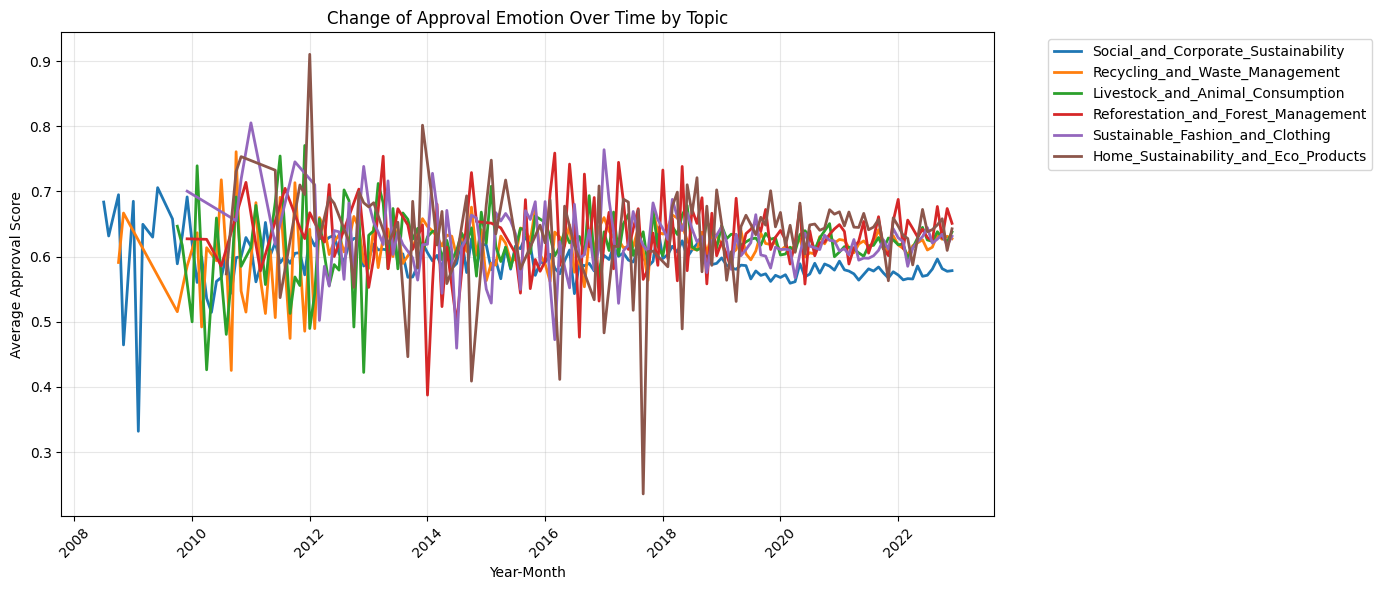

In [ ]:
emo_cols = [c for c in dfm.columns if c.startswith("emo_")]

# Aggregate: average emotion scores per topic per month
emo_trend = (
    dfm.groupby(["year_month", "Topic_Name"])[emo_cols]
    .mean()
    .reset_index()
)

# Plot trend for 3–4 key emotions
key_emotions = ["emo_caring", "emo_curiosity", "emo_realization", "emo_approval"]

for emo in key_emotions:
    plt.figure(figsize=(14,6))
    sns.lineplot(
        data=emo_trend,
        x="year_month",
        y=emo,
        hue="Topic_Name",
        linewidth=2
    )
    plt.xticks(rotation=45)
    plt.title(f"Change of {emo.replace('emo_', '').capitalize()} Emotion Over Time by Topic")
    plt.xlabel("Year-Month")
    plt.ylabel(f"Average {emo.replace('emo_', '').capitalize()} Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

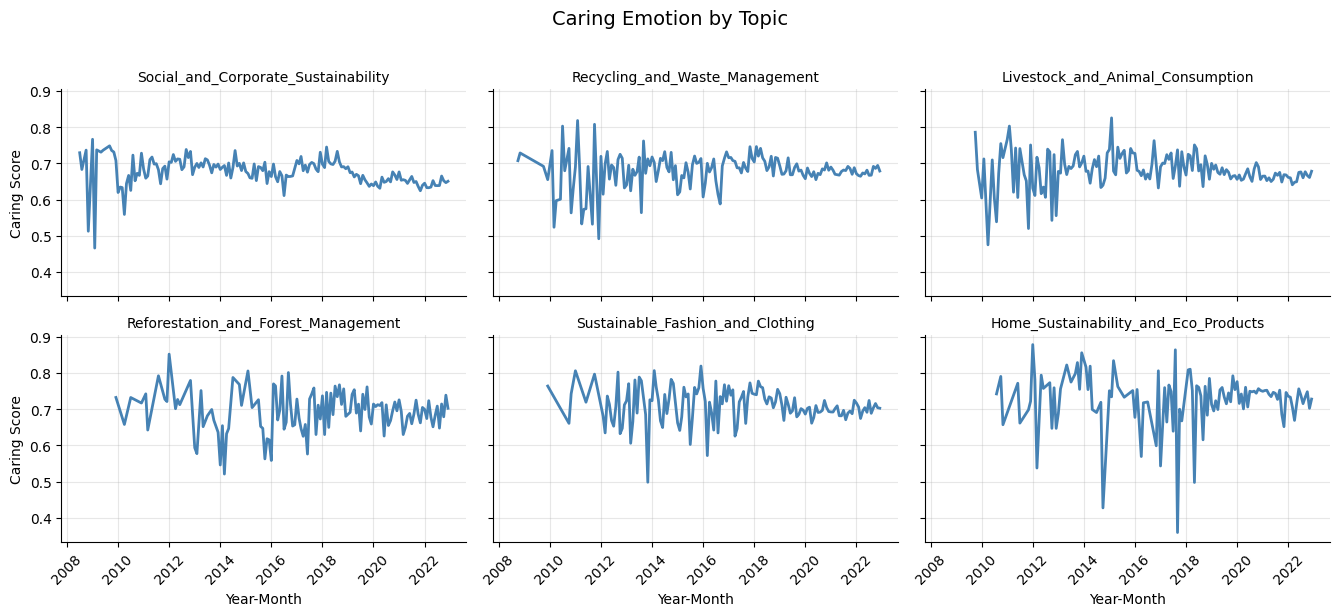

In [ ]:
g = sns.FacetGrid(emo_trend, col="Topic_Name", col_wrap=3, height=3, aspect=1.5)
g.map(plt.plot, "year_month", "emo_caring", linewidth=2, color='steelblue')
g.set_titles("{col_name}")
g.set_axis_labels("Year-Month", "Caring Score")
g.fig.suptitle("Caring Emotion by Topic", y=1.02, fontsize=14)
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## Preparing time columns
dfm["created_dt"] = pd.to_datetime(dfm["created_dt"], errors="coerce")
dfm["year"] = dfm["created_dt"].dt.year
dfm["month"] = dfm["created_dt"].dt.month
dfm["year_month"] = dfm["created_dt"].dt.to_period("M").astype(str)

## **Emotion change over time by topic**

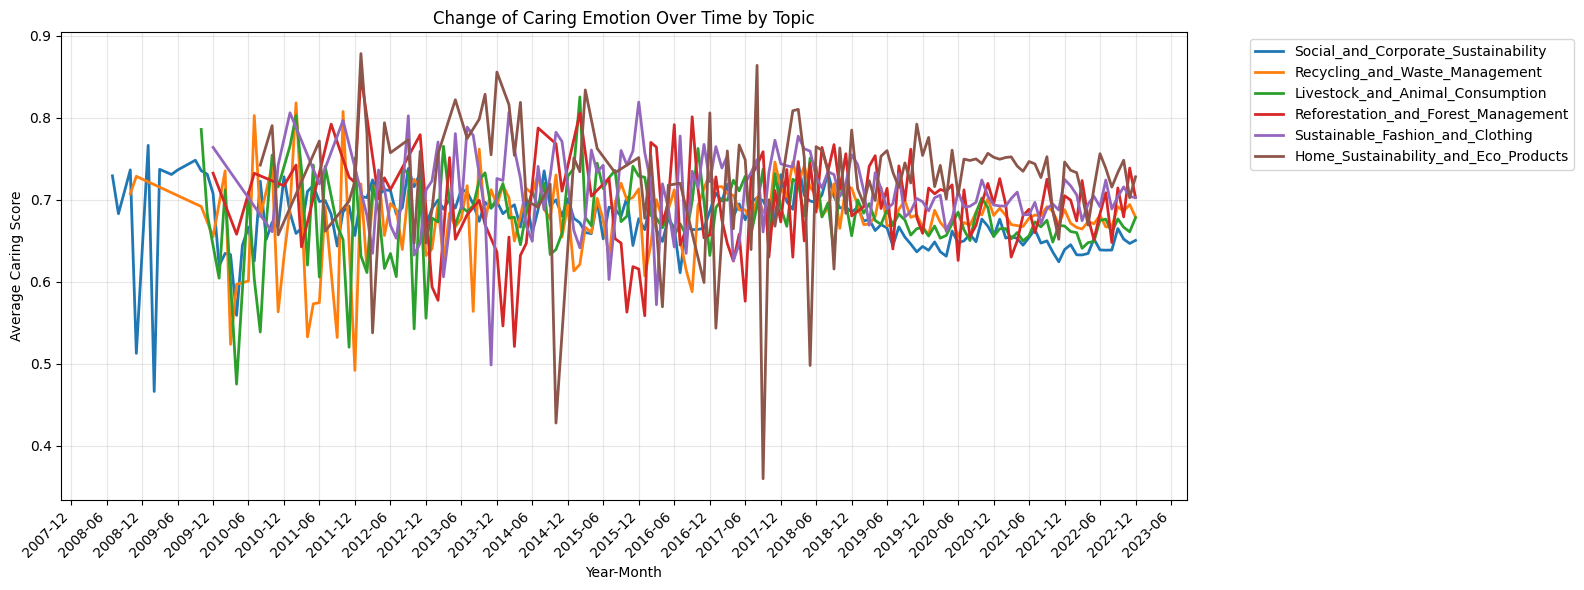

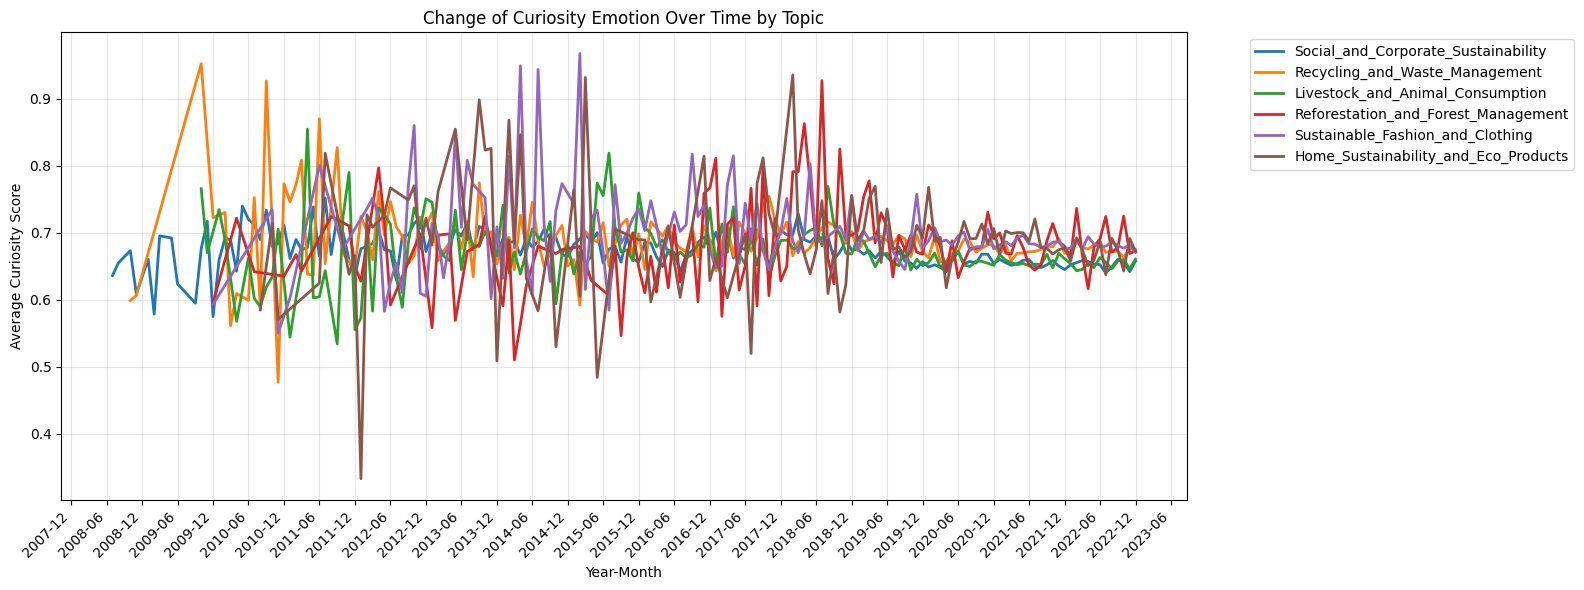

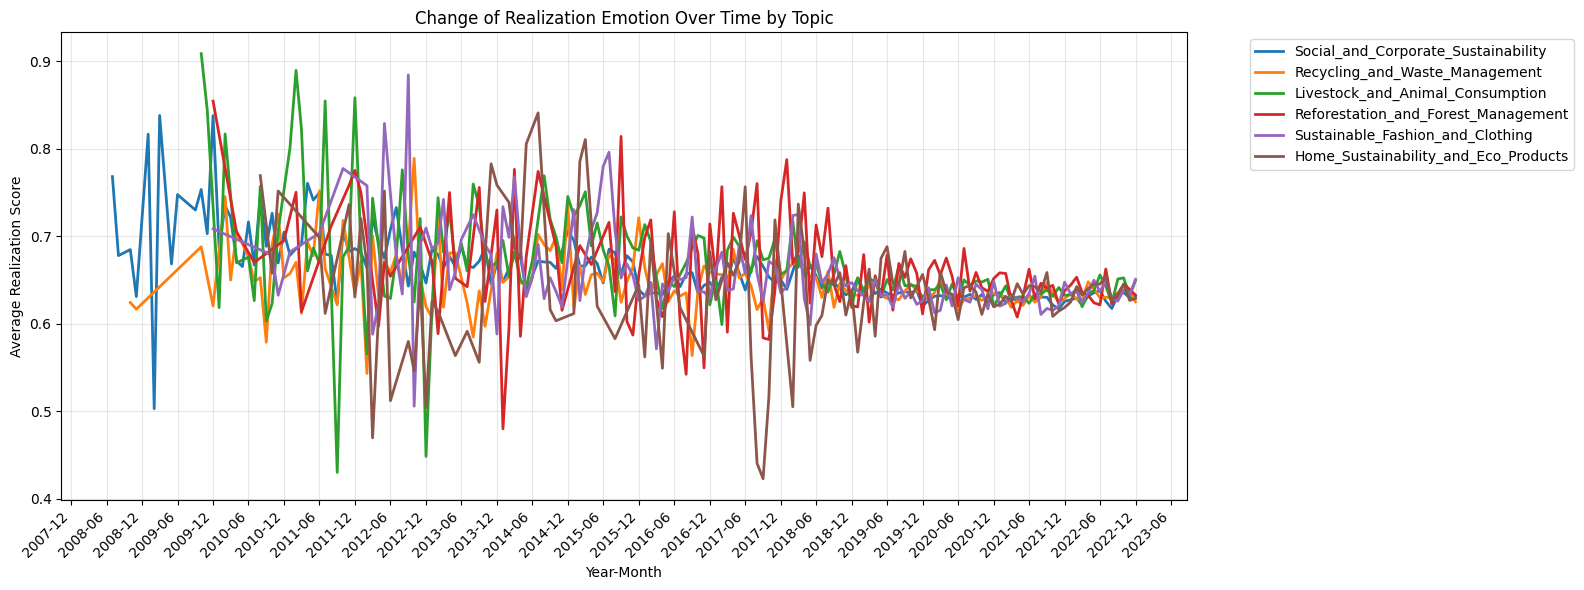

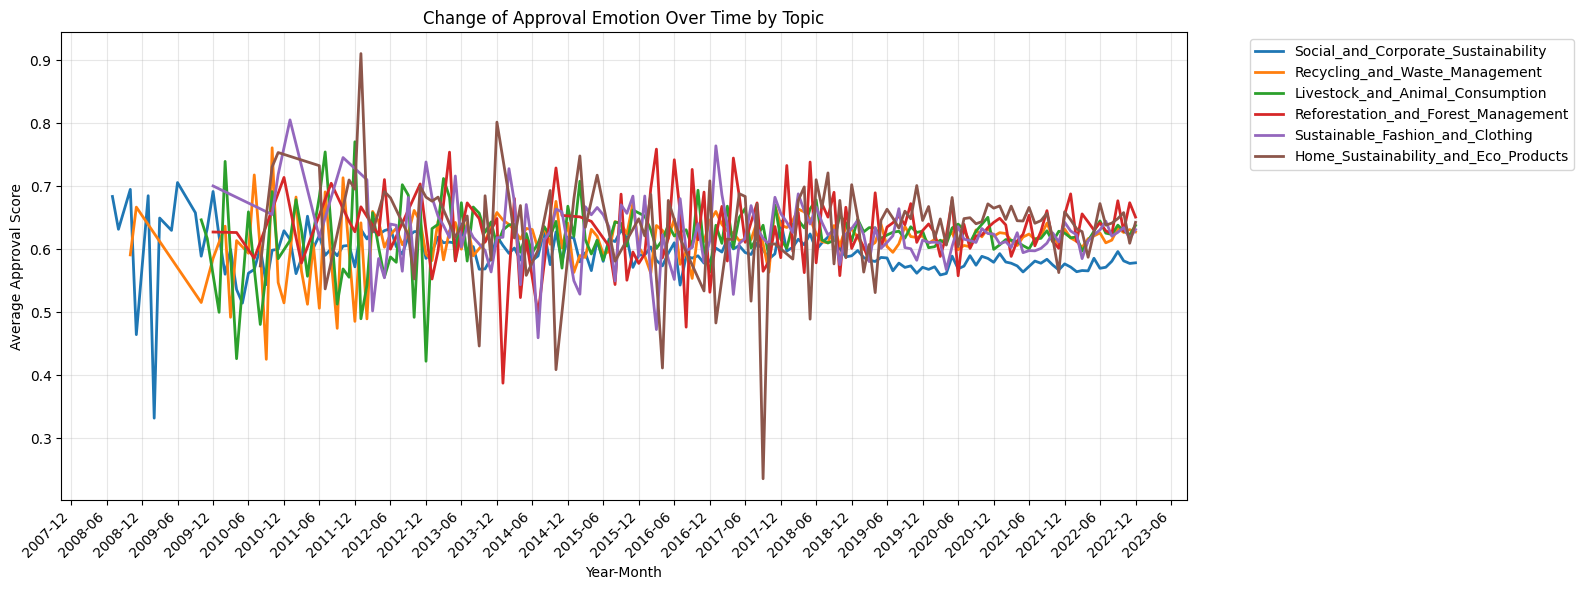

In [ ]:
# Convert year_month to datetime
emo_trend["year_month"] = pd.to_datetime(emo_trend["year_month"])

key_emotions = ["emo_caring", "emo_curiosity", "emo_realization", "emo_approval"]

for emo in key_emotions:
    plt.figure(figsize=(16,6))

    sns.lineplot(
        data=emo_trend,
        x="year_month",
        y=emo,
        hue="Topic_Name",
        linewidth=2
    )

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))     # tick every 6 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))     # show YYYY-MM

    plt.xticks(rotation=45, ha="right")
    plt.grid(alpha=0.3)
    plt.title(f"Change of {emo.replace('emo_', '').capitalize()} Emotion Over Time by Topic")
    plt.xlabel("Year-Month")
    plt.ylabel(f"Average {emo.replace('emo_', '').capitalize()} Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

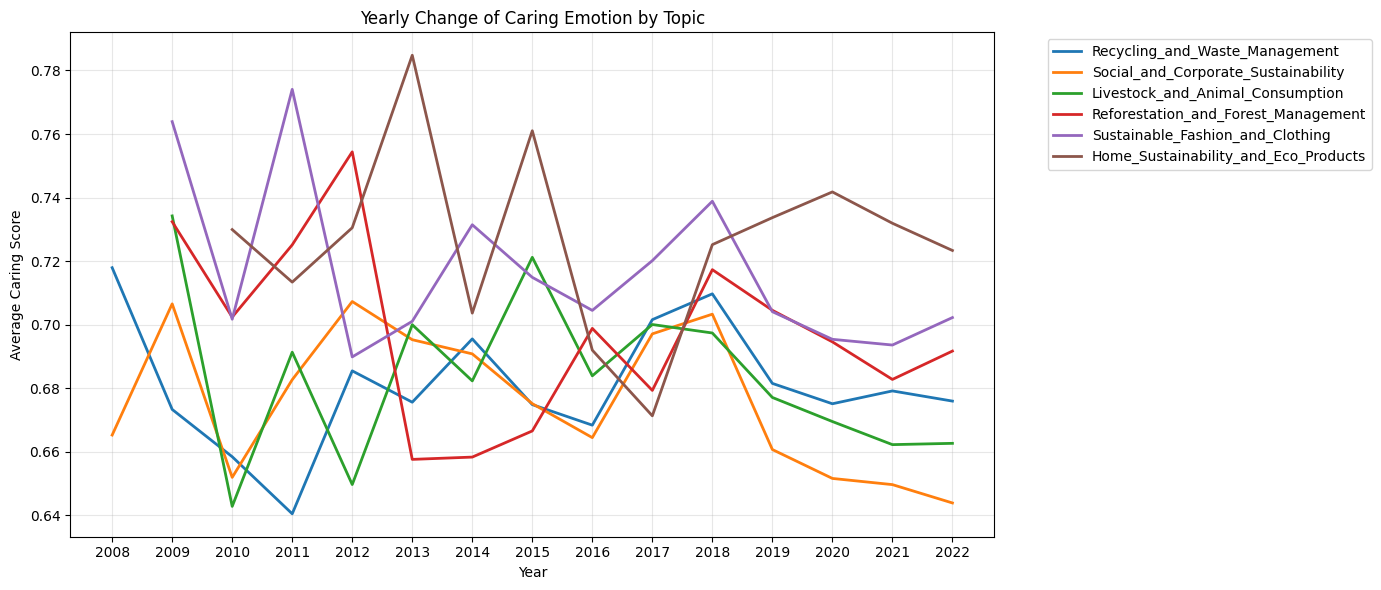

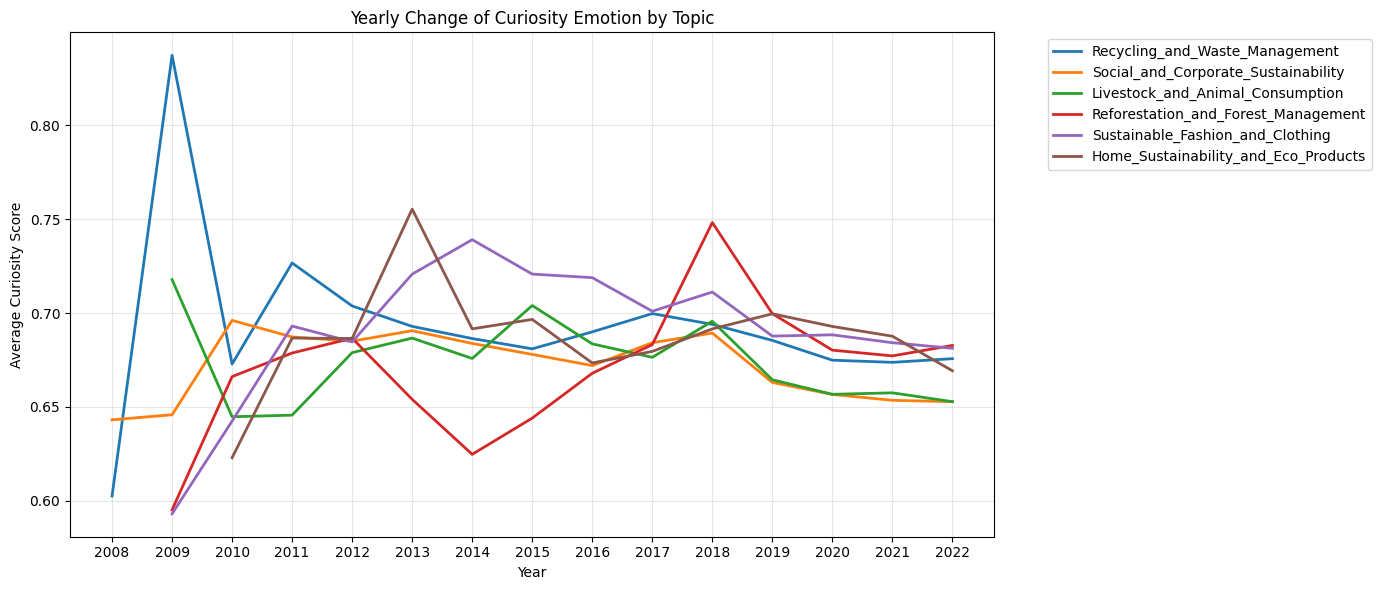

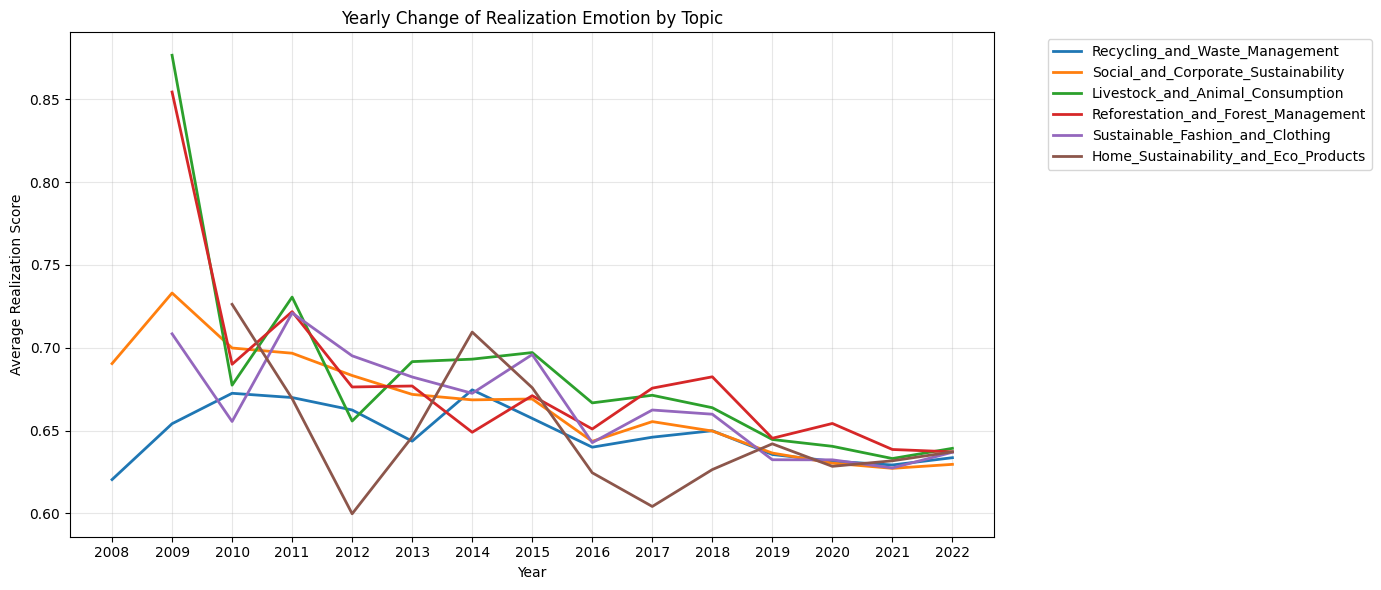

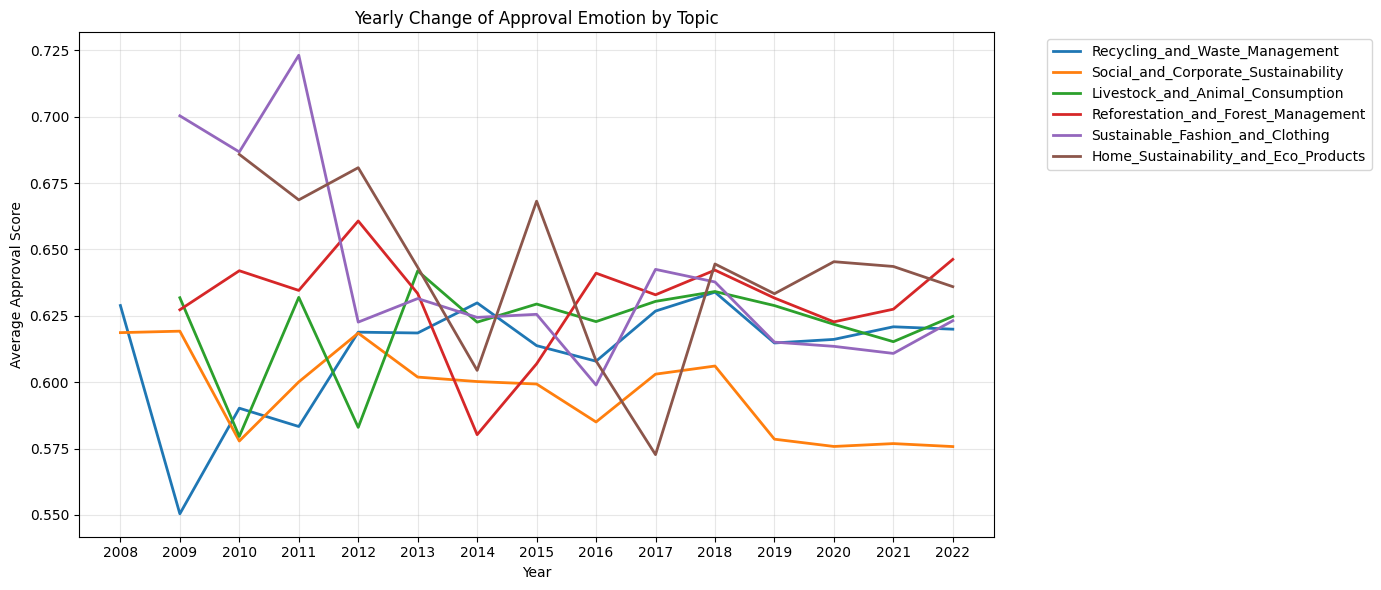

In [ ]:
emo_trend["year"] = emo_trend["year_month"].dt.year

for emo in key_emotions:
    plt.figure(figsize=(14,6))

    sns.lineplot(
        data=emo_trend.groupby(["year", "Topic_Name"])[emo].mean().reset_index(),
        x="year",
        y=emo,
        hue="Topic_Name",
        linewidth=2
    )

    plt.grid(alpha=0.3)
    plt.xticks(sorted(emo_trend["year"].unique()))
    plt.title(f"Yearly Change of {emo.replace('emo_', '').capitalize()} Emotion by Topic")
    plt.xlabel("Year")
    plt.ylabel(f"Average {emo.replace('emo_', '').capitalize()} Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## **Yearly Average Emotion Heatmap**

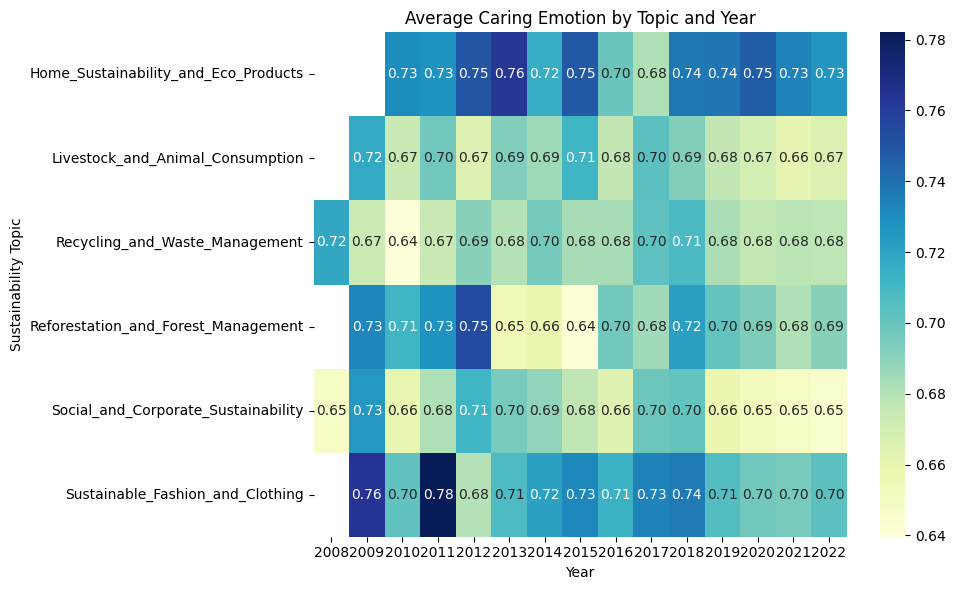

In [ ]:
emo_year = (
    dfm.groupby(["year", "Topic_Name"])[emo_cols]
    .mean()
    .reset_index()
)

# Example: heatmap for caring
pivot = emo_year.pivot(index="Topic_Name", columns="year", values="emo_caring")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Average Caring Emotion by Topic and Year")
plt.xlabel("Year")
plt.ylabel("Sustainability Topic")
plt.tight_layout()
plt.show()

The time-series analysis revealed dynamic emotional patterns across sustainability themes from 2008–2022. Overall “Caring” and “Curiosity” remained dominant, indicating a consistently empathetic and inquisitive tone in community discussions.

“Corporate Sustainability” and “Policy” topics showed increasing Realization and Approval emotions after 2018, suggesting growing optimism about institutional responses. “Recycling” and “Fashion” topics exhibited stable Caring but declining Curiosity, possibly reflecting topic saturation.

The heatmap further confirmed that emotional intensity peaked during 2019–2021 periods corresponding with global climate movements. These findings align with prior research that social media discussions on sustainability often reflect collective emotional engagement rather than polarized sentiment.

**Check all topics and names**

In [ ]:
# See all unique topics, numbers, and names
topic_info_clean = pd.read_csv("/content/drive/MyDrive/r_sustainability/topic_info_clean.csv")

print(topic_info_clean[["topic", "Topic_Num", "Topic_Name"]]
      .drop_duplicates()
      .sort_values("Topic_Num"))


   topic  Topic_Num                            Topic_Name
0     -1          1      Sustainability_Issues (Outliers)
1      0          2   Social_and_Corporate_Sustainability
2      1          3        Recycling_and_Waste_Management
3      2          4      Livestock_and_Animal_Consumption
4      3          5      Sustainable_Fashion_and_Clothing
5      4          6  Home_Sustainability_and_Eco_Products
6      5          7   Reforestation_and_Forest_Management


**How many comments per topic**

In [ ]:
dfm["Topic_Name"].value_counts()

Topic_Name
Social_and_Corporate_Sustainability     77681
Recycling_and_Waste_Management          22404
Livestock_and_Animal_Consumption        19811
Sustainable_Fashion_and_Clothing         5421
Home_Sustainability_and_Eco_Products     3157
Reforestation_and_Forest_Management      2594
Name: count, dtype: int64

## Bar chart: number of comments per topic

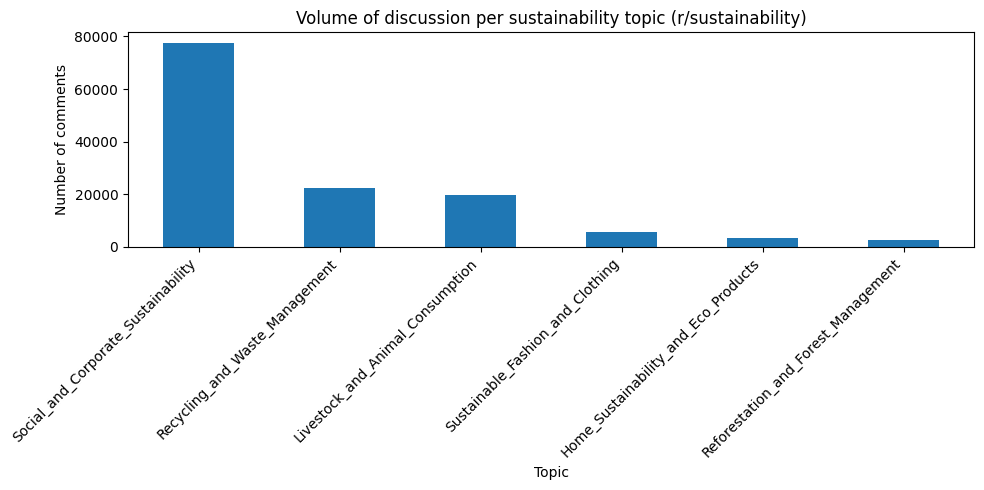

In [ ]:
topic_counts = (
    dfm.groupby("Topic_Name")["id"]
       .count()
       .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
topic_counts.plot(kind="bar")
plt.ylabel("Number of comments")
plt.xlabel("Topic")
plt.title("Volume of discussion per sustainability topic (r/sustainability)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Top topics: ['Corporate_Sustainability', 'Food_and_Agriculture', 'Recycling_and_Waste', 'Sustainable_Fashion']


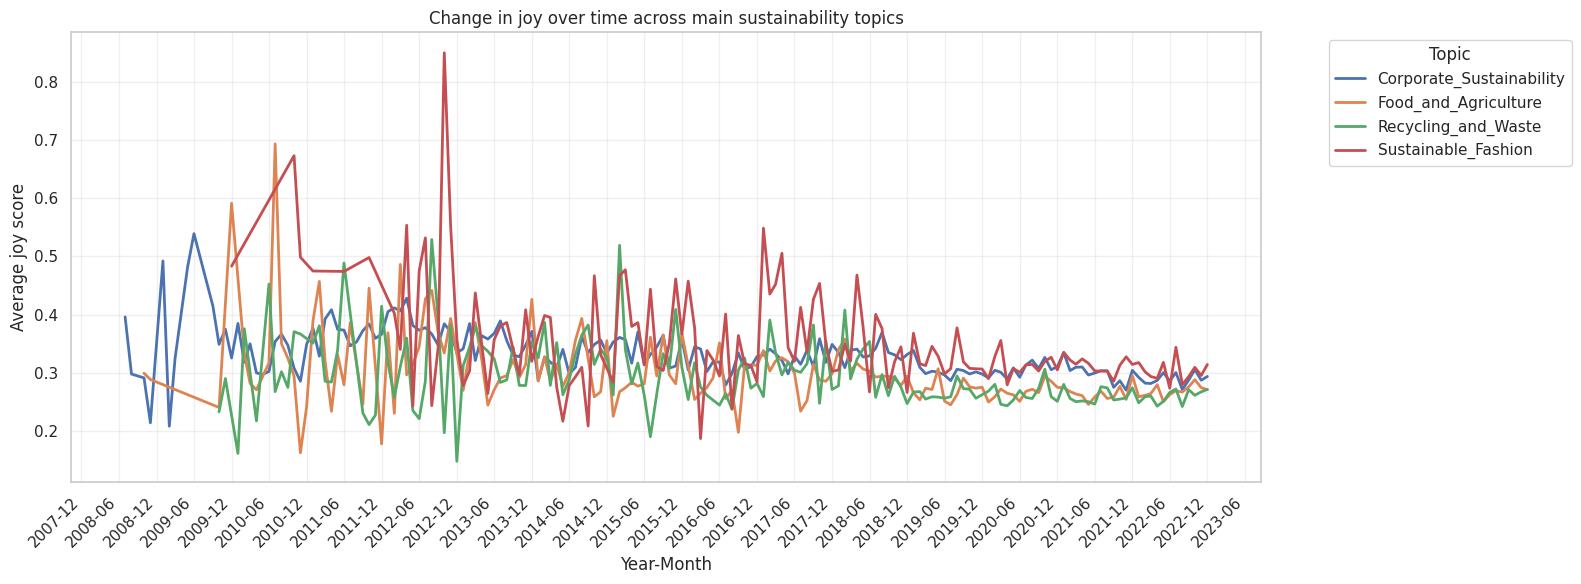

In [ ]:
# picking top 4 topics by volume
top_topics = (
    dfm[dfm["Topic_Name"] != "General_Sustainability"]
      .groupby("Topic_Name")["id"]
      .count()
      .sort_values(ascending=False)
      .head(4)
      .index
      .tolist()
)

print("Top topics:", top_topics)

# compute monthly mean joy per topic
joy_ts = (
    dfm[dfm["Topic_Name"].isin(top_topics)]
      .groupby(["year_month", "Topic_Name"])["emo_joy"]
      .mean()
      .reset_index()
)

# Convert year_month to real datetime
joy_ts["year_month"] = pd.to_datetime(joy_ts["year_month"])

plt.figure(figsize=(16,6))

# Plot
for t in top_topics:
    sub = joy_ts[joy_ts["Topic_Name"] == t]
    plt.plot(sub["year_month"], sub["emo_joy"], label=t, linewidth=2)

# Fix x-axis (tick every 6 months)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Year-Month")
plt.ylabel("Average joy score")
plt.title("Change in joy over time across main sustainability topics")
plt.tight_layout()
plt.show()

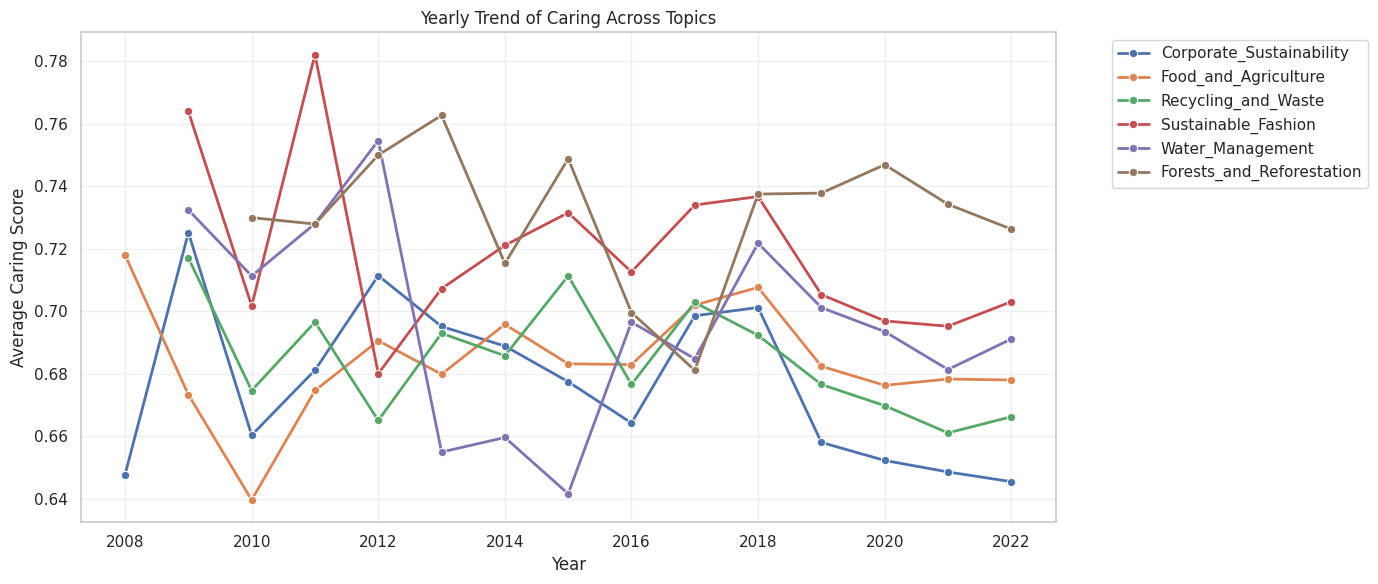

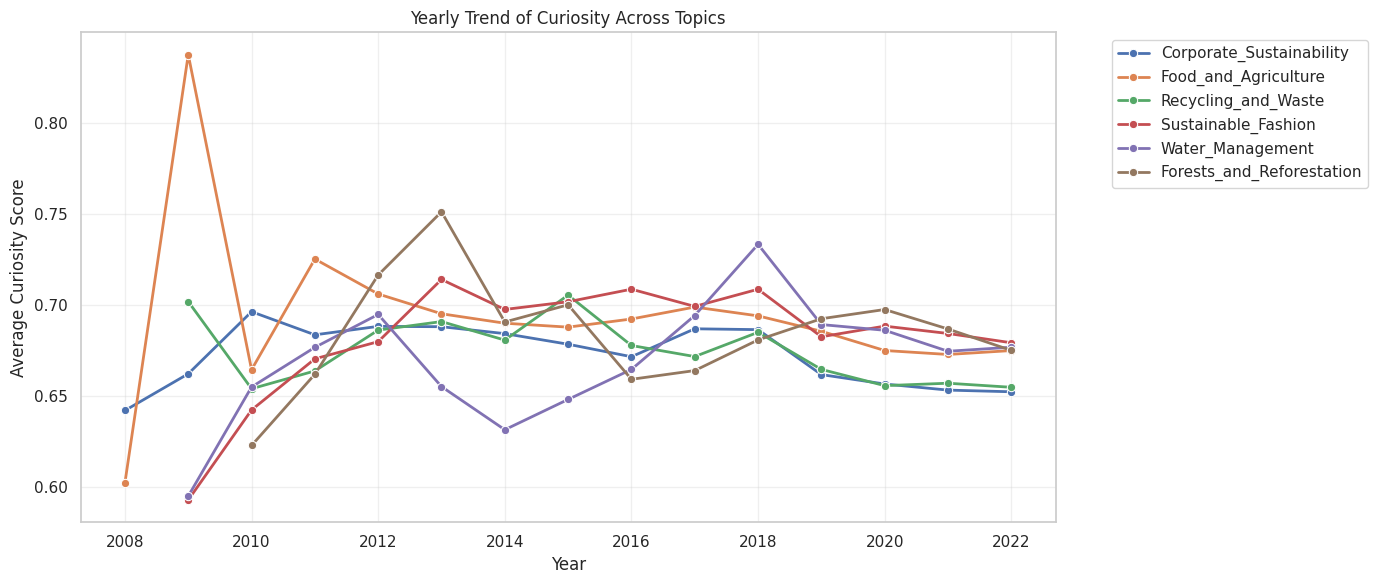

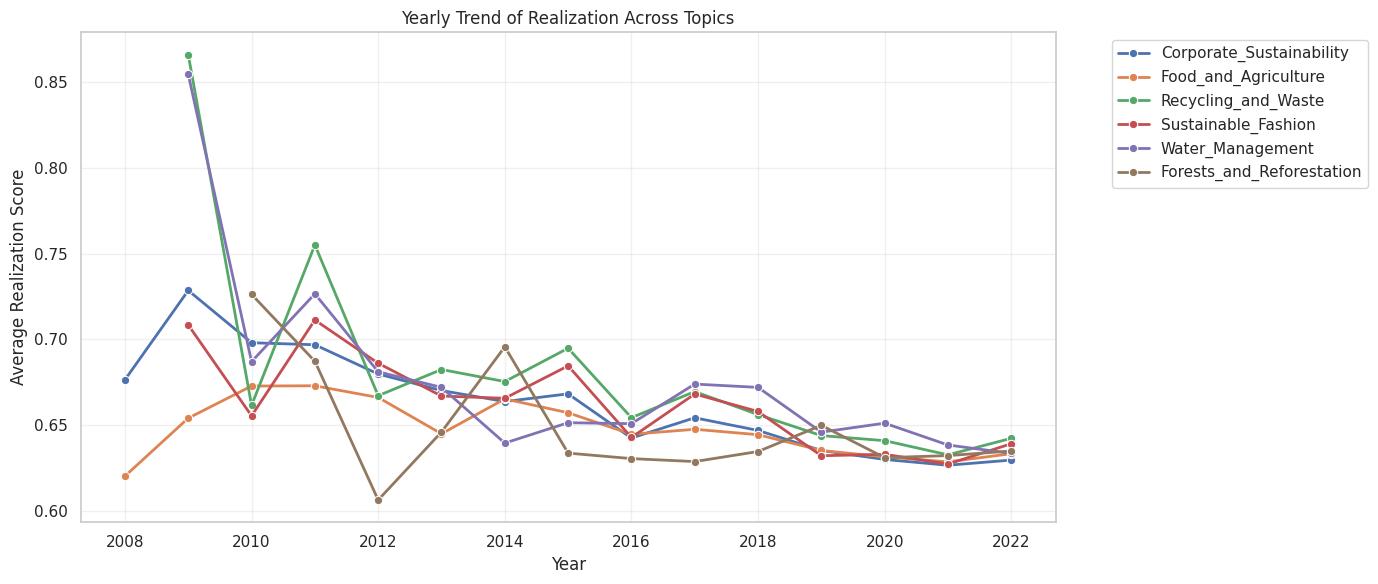

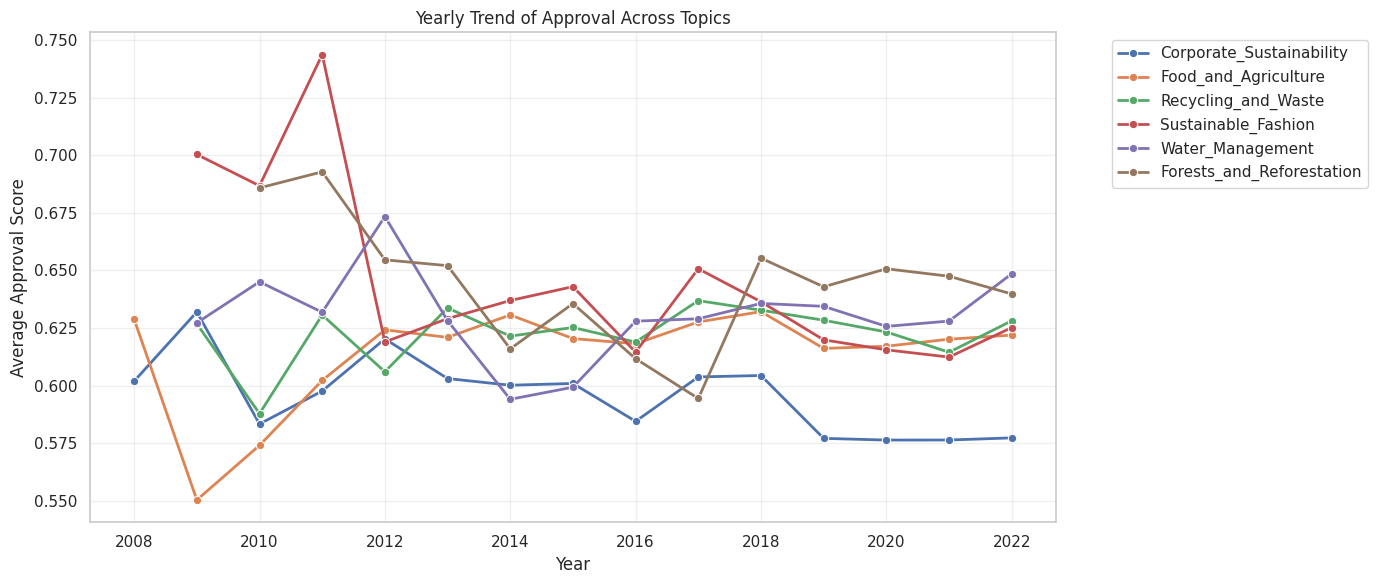

In [ ]:
# Extract YEAR only
dfm["year"] = dfm["created_dt"].dt.year

# Emotion columns
emo_cols = [c for c in dfm.columns if c.startswith("emo_")]

# Aggregate YEARLY averages per topic
emo_yearly = (
    dfm.groupby(["year", "Topic_Name"])[emo_cols]
    .mean()
    .reset_index()
)

# Key emotions to plot
key_emotions = ["emo_caring", "emo_curiosity", "emo_realization", "emo_approval"]

# Plot each emotion
for emo in key_emotions:
    plt.figure(figsize=(14,6))
    sns.lineplot(
        data=emo_yearly,
        x="year",
        y=emo,
        hue="Topic_Name",
        linewidth=2,
        marker="o"
    )
    plt.title(f"Yearly Trend of {emo.replace('emo_', '').capitalize()} Across Topics")
    plt.xlabel("Year")
    plt.ylabel(f"Average {emo.replace('emo_', '').capitalize()} Score")
    plt.grid(alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Top topics: ['Corporate_Sustainability', 'Food_and_Agriculture', 'Recycling_and_Waste', 'Sustainable_Fashion']


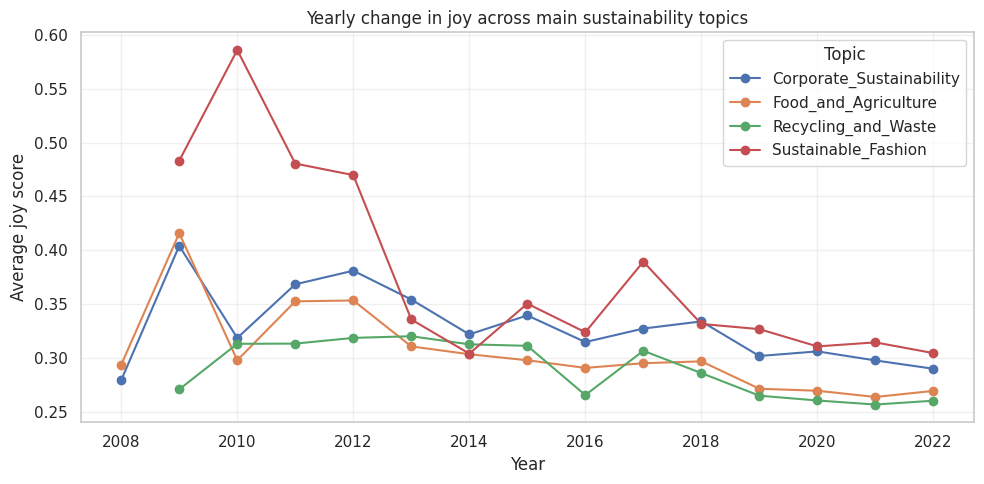

In [ ]:
# Make sure we have a 'year' column
dfm["year"] = dfm["created_dt"].dt.year

# Pick top 4 topics by volume (excluding the general bucket)
top_topics = (
    dfm[dfm["Topic_Name"] != "General_Sustainability"]
      .groupby("Topic_Name")["id"]
      .count()
      .sort_values(ascending=False)
      .head(4)
      .index
      .tolist()
)
print("Top topics:", top_topics)

# Compute YEARLY mean joy per topic
joy_yearly = (
    dfm[dfm["Topic_Name"].isin(top_topics)]
      .groupby(["year", "Topic_Name"])["emo_joy"]
      .mean()
      .reset_index()
)

# Plot yearly joy trend for the 4 biggest topics
plt.figure(figsize=(10,5))
for t in top_topics:
    sub = joy_yearly[joy_yearly["Topic_Name"] == t]
    plt.plot(sub["year"], sub["emo_joy"], marker="o", label=t)

plt.legend(title="Topic")
plt.xlabel("Year")
plt.ylabel("Average joy score")
plt.title("Yearly change in joy across main sustainability topics")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()